In [1]:
using PyPlot
using Polynomials

In [2]:
###################################################################################
###################################################################################
########################                                ###########################
########################       DEFINE CLASSES           ###########################
########################                                ###########################
########################                                ##########################
########################                                ##########################
###################################################################################
###################################################################################


In [3]:
type Trial
    Trajectory
    Latency
    SearchPreference
    ActionMap
    Valuemap
    Error
end

In [4]:
type Day 
    trial::Any
    Day()=new(Trial[]);
    Platform::Any
end

In [5]:
type Experiment 
    day::Any
        Experiment()=new(Day[])

    PlaceCells::Any
end

In [6]:
type Rat
    experiment::Any
    Rat()=new(Experiment[])
    parameters
end

In [7]:
###################################################################################
###################################################################################
########################                                ###########################
########################       DEFINE FUNCTIONS         ###########################
########################                                ###########################
########################                                ##########################
########################                                ##########################
###################################################################################
###################################################################################


In [8]:
#The algorithm places n points, of which the kth point is put at distance sqrt(k-1/2) from the boundary (index begins with k=1), and with polar angle 2*pi*k/phi^2 where phi is the golden ratio. Exception: the last alpha*sqrt(n) points are placed on the outer boundary of the circle, and the polar radius of other points is scaled to account for that. This computation of the polar radius is done in the function radius.

function  radius(k,n,b) # k index of point on the boundary, n number of total points, b number of boundary points
    if k>n-b
        r = 1;            # put on the boundary
    else
        r = sqrt(k-1/2)/sqrt(n-(b+1)/2);     # computation of radius of the different points 
    end
end



radius (generic function with 1 method)

In [9]:
# sunflower seed arrangement :
function sunflower(n, R, alpha)   # n number of centers,
    # alpha is indicating how much one cares about the evenness of boundary , chose 2 to have nice trade off
    # R is the radius of the circle in cm
    r=Array{Any}( n);
    theta=Array{Any}( n);
    b = round(alpha*sqrt(n));      # number of boundary points
    phi = (sqrt(5)+1)/2;           # golden ratio
    
    for k=1:n
        r[k] = R*radius(k,n,b); # computation of the radius of each point 
        theta[k] = 2*pi*k/phi^2; # computation of the angle of each point 
        
        #plot(r*cos.(theta), r*sin.(theta), "m");
    end
    # scatter(r.*cos.(theta), r.*sin.(theta));#, marker='o', "m");
    X=r.*cos.(theta); 
    Y=r.*sin.(theta);
    return hcat(X, Y)
end

Xplacecell=sunflower(493, 100, 2)[:,1];
Yplacecell=sunflower(493, 100, 2)[:,2];

In [10]:
# Define the place activity :

# Define activity as a function of position 
###### !!!!!!! POSITIONS TO BE GIVEN IN THE SAME UNITE THAN THE SIGMA ###### !!!!!!!
function place_activity(x,y,xpc,ypc,σ) # x,y 2 scalars the position of the rat, xpc,ypc 2 vectors posiions of all place cells
    N=length(xpc); # N number of place cells 
    actplacecell=zeros(N,1); # define empty array of activity 
    
    for k=1:N # k is the k-th place cell
        actplacecell[k]=exp(-((x-xpc[k])^2+(y-ypc[k])^2)^2/(2σ^2));
    end
    return actplacecell
end 

place_activity (generic function with 1 method)

In [11]:
# Calculate reward as a function of position 
function reward(x,y,xp,yp,r) # x,y position of the rat and xp,yp position of the platform, r radius of the platform
    if (x-xp)^2+(y-yp)^2<= r^2 # if the rat is in the platform
        R=1;
    else # else 
        R=0;
    end 
    
end


reward (generic function with 1 method)

In [12]:
# Function to return the cumulative sum of the terms of a vector : 
function cumul(A) # A vector 
    Acum=Array{Any}(length(A));
    for k=1:length(A)
       Acum[k]=sum(A[1:k]);
    
    end
    return Acum
end

cumul (generic function with 1 method)

In [13]:
# This function tells within wich index column is located x
function indice(Acum,x) # x number, Acum vector
    
    for i=1:length(Acum)
       if i==1
           if x<Acum[i]
                return i
            end
        else
            if Acum[i-1]<x<=Acum[i]
                return i
            end
        end
    end  
        
end

indice (generic function with 1 method)

In [51]:
###################################################################################
################## GENERAL THINGS THAT DONT CHANGE WITHIN TRIALS ##################
###################################################################################

# Creating the circle and the place cells:
R= 100; # Radius of the circle in cm
r=5; # Radius of the platform  in cm
radiussearchpref=20; # radius of the area in which we calculate searchpreference 

# Motion characteristic 
speed=30; # speed of the rat in cm.s-1
# Different possible directions 
angles=[pi/2, pi/4,0,7*pi/4, 3*pi/2,5*pi/4,pi,3*pi/4];


# Trial characteristic :
T=120; # maximal duration of a trial in seconds
dt=0.1; # timestep in s 


# Place cells 
N=493; # number of place cells 
Xplacecell=sunflower(N,R,2)[:,1]; # absciss place cells  
Yplacecell=sunflower(N,R,2)[:,2]; # y place cells 
σ=0.30*100; # width of place cell fields, in centimeters


# Action cells : 
n=8; # number of action cells 


# Potential positions of the platform : 
Xplatform=[0.3,0,-0.3,0,0.5,-0.5,0.5,-0.5].*R; # in cm
Yplatform=[0,0.3,0,-0.3,0.5,0.5,-0.5,-0.5].*R;# in cm

# Potential Starting positions of the rat :
Xstart=[0.95,0,-0.95,0].*R; # East, North, West, South
Ystart=[0,0.95,0,-0.95].*R;

# Define number of rats, number of days and numbers of trials per day
numberofdays=1;
numberofrats=1;
numberoftrials=20;

times=collect(0:dt:T+dt);

In [68]:
# Parameter that regulate the choice between former angle and new angle 
momentum=1.0;



# Learning variables : 
γ=0.98; # Discount factor.  they dont precise the value  
Z=0.9; # actor learning rate
W=0.9; # critic learning rate


In [74]:
#########################################################################
#############          LOOP       1   EXPERIMENT FOR 1 DAY 1 RAT   ######################
#########################################################################

rats=Rat();
rats.parameters=[momentum,γ,Z,W]; # Save different parameters 
currentexperiment=Experiment(); # Creating the experiment 
currentexperiment.PlaceCells=hcat(Xplacecell,Yplacecell); # Store location of place cells 

println("start of experiments")

for indexrat=1:numberofrats

# Initialisation variables :
w=zeros(N,1);
z=zeros(N,n);    
    
        ##########  ##########  ##########  ##########   ########## 
    ##########  ##########  START EXPERIMENT  ##########  ##########  
        ##########  ##########  ##########  ##########   ########## 

# currentexperiment=Experiment(); # Creating the experiment 
#currentexperiment.PlaceCells=hcat(Xplacecell,Yplacecell); # Store location of place cells 
    
    println("start of 1 experiment")
    
    for indexday=1:numberofdays
        # Everyday the location of the platform changes
        # Chose platform :
        #indexplatform=rand(1:8); # take ith platform 
        #xp=Xplatform[indexplatform];
        #yp=Yplatform[indexplatform]; 
        xp=40;
        yp=40;
        
        currentday=Day(); # creating a day 
        currentday.Platform=hcat(xp,yp);  
                    
            ##########  ##########  ##########  ##########  
        ##########  ##########  START DAY ##########  ##########  
            ##########  ##########  ##########  ##########  
            println("start of day")
        
                    # Chose starting position :
              
        # just to try if it learns better
        
            indexstart=rand(1:4); # take indexstart-th starting position : chose randomnly between 4 possibilities 1 East 2 North 3 West 4 South
            positionstart=[Xstart[indexstart] Ystart[indexstart]];
            
        
        for indextrial=1:numberoftrials ##########  
            
            ## Chose starting position :
            #        
            #indexstart=rand(1:4); # take indexstart-th starting position : chose randomnly between 4 possibilities 1 East 2 North 3 West 4 South
            #position=[Xstart[indexstart] Ystart[indexstart]];
            
            position=positionstart;
            
            # Initialize reward 
            re=0;
            
            # Initialise index to save the trajectory and the values 
            k=1;
            # initialise time 
            t=times[k];
            historyX=Float64[];
            historyY=Float64[];
            #valuemap=Float64[];
            error=Float64[];
            searchpref=0;
            arg=0;        
            timeout=0;        
            prevdir=[0 0];    
            ##########  ##########  ##########  ##########   ########## 
            ##########  ##########  START TRIAL ##########  ##########  
            ##########  ##########  ##########  ##########   ########## 
                println("start of trial")
            
                while t<=T && re==0
    
                        if t==T
                            X=xp;
                            Y=yp;
                            position=[X Y];
                            timeout=1; # if we have to put the rat on the platform then we dont reinforce the actor but only the critic
                        println("timeout is $(timeout)")
                        end
                        
                        
                    # Store former position to be able to draw trajectory
                    push!(historyX,position[1]) 
                    push!(historyY,position[2])
                    
                    
                         ###  Compute reward ### 
                    re=reward(position[1],position[2],xp,yp,r); 
                    
                         # compute new activity of pace cells :
                    actplacecell=place_activity(position[1],position[2],Xplacecell,Yplacecell,σ);

                    ### Compute Critic ###
                    C=dot(w,actplacecell); # current estimation of the future discounted reward 
                    
                    ####### Take decision and move to new position : ########
                    # Compute the activity of action cells 
    
                    #  Compute action cell activity    
                    actactioncell=transpose(z)*actplacecell; # careful z contains place cells in rows and action cells in column 
                        if maximum(actactioncell)>=100
                            actactioncell=100.*actactioncell./maximum(actactioncell); 
                        end
                    
                    # Compute probability distribution : 
                    Pactioncell=exp.(2.*actactioncell)./sum(exp.(2.*actactioncell)); 
                    # be sure it does not give rise to errors by thrsholding to the maximum number allowed
                    #     for c in 1:length(Pactioncell)
                    #          if Pactioncell[c]==Inf
                    #                  Pactioncell[c]=realmax(Float64)-100;
                    #            elseif isnan(Pactioncell[c])
                    #                Pactioncell[c]=realmax(Float64)-100;
                    #           end
                    #      end
                    #
                
                    # Compute summed probability distribution:
                    SumPactioncell=cumul(Pactioncell);
                    # Generate uniform number between 0 and 1 :
                    x=rand();
                    # println(SumPactioncell)
                    # now chose action: 
                    indexaction=indice(SumPactioncell,x); # Chose which action between the 8 psosibilities
                    argdecision=angles[indexaction]; # compute the coreesponding angle 
                    newdir=[cos(argdecision) sin(argdecision)];
                    dir=(newdir./(1.0+momentum).+momentum.*prevdir./(1.0+momentum));
                    prevdir=dir;
                    # arg=α*formerarg+β*argdecision; # to constrain the angle to prevent from sharp angles
                    # arg=argdecision; # not good because angles too sharp
                    # Store former position 
                    formerposition=position;
                    # Compute new position : 
                    position=position.+dt.*speed.*dir; 
                    
                    X=position[1];
                    Y=position[2];
                    Xf=formerposition[1];
                    Yf=formerposition[2];
                
                    # We code walls as reflectors :
                        if X^2+Y^2>R^2 # if we are out of the circle 
                            # find the position between former position and current position that is exactly on the circle :
                            # Create Polynomial with a parameter lambda that represent the absciss along the segment
                            # search the value of lambda for which we are crossing the circle    
                            polynom=Poly([Xf^2+Yf^2-R^2,2*X*Xf+2*Y*Yf-2*Xf^2-2*Yf^2,Xf^2+Yf^2+X^2+Y^2-2*X*Xf-2*Y*Yf]); # using poly creates a polynomial, coefficient are in order of increasing exposant 
                            # find the root of this polynomial that is between 0 and 1 (there is just one by I dont know which theorem)
                            λ=roots(polynom)[find(x -> 0<x <1,roots(polynom))];
                            λ=maximum(λ); # to convert from array of float to float 
                            Xlambda=λ*X+(1-λ)Xf; # position of the point that is on the circle 
                            Ylambda=λ*Y+(1-λ)Yf;
                            delta=norm([Xlambda-X,Ylambda-Y]); # distance of the point to Xlambda Ylambda
                                
                            #anglereflect=acos(dot([Xlambda, Ylambda],[Xf-Xlambda,Yf-Ylambda])/(norm([Xlambda, Ylambda])*norm([Xf-Xlambda,Yf-Ylambda]))); # compute the angle between the former position and the radius linking the point in the circle to the center 
                            #anglerotation=acos(Xlambda/norm([Xlambda, Ylambda])); # angle of rotation to calculate the new coordonnee, angle between the point in the circle and the x axis
                            # Find the intersection between the line starting from X,Y in the direction of Xlambda and Ylambda and the circle of centre Xlambda Ylambda of radius delta
                            poly2=Poly([Y^2-2*Ylambda*Y+(Ylambda^2)+X^2-2*Xlambda*X+(Xlambda^2)-delta^2, -2*Ylambda*Y/R+2*Ylambda^2/R-2*Xlambda*X/R+2*Xlambda^2/R ,Ylambda^2/R^2+Xlambda^2/R^2]);
            
                            # Problem with root is the precision : sometimes the first root given is reaaally near the first point in which case we want the second root
                            deplacement=maximum(roots(poly2)[find(x -> 0<x ,roots(poly2))]); 
                            
                                
                            # Compute new position : we just move following the inverse vector of Xlambda,Ylambda of the distance we computed
                            Xnew=X-deplacement*Xlambda/R;
                            Ynew=Y-deplacement*Ylambda/R;
                            #X=-delta*cos(anglerotation)*cos(anglereflect)-delta*sin(anglerotation)*sin(anglereflect)+delta*sin(anglerotation)*cos(anglereflect)+delta*cos(anglerotation)*sin(anglereflect)+Xlambda;   
                            #Y=-delta*sin(anglerotation)*cos(anglereflect)+delta*sin(anglerotation)*sin(anglereflect)-delta*cos(anglerotation)*cos(anglereflect)+delta*cos(anglerotation)*sin(anglereflect)+Ylambda;   
                                if Xnew^2+Ynew^2>R^2 # if we are still out of the circle 
                                    println("we are still out")
                                    break
                                end

                            X=Xnew;
                            Y=Ynew;
                            position=[X Y];    
                        end
                    
                    # If we are now at the very edge of the maze, move us in a little bit :
                        if X^2+Y^2==R^2
                            position = (position./(X^2+Y^2))*(R - 1);
                        end
                
                    # compute new activity of pace cells :
                    actplacecell=place_activity(position[1],position[2],Xplacecell,Yplacecell,σ);
                    println("norm of activity $(norm(actplacecell))")

                
                        if re==1 # if we are on the platform 
                           ###  Compute error ###
                            Cnext=0;
                          println("reward is $(re)")
                        else 
                            Cnext=dot(w,actplacecell);# new estimation of the future discounted reward 
                        end 
                    
                
                    #### Compute error  ####
                    err=re+γ*Cnext-C;
                    
                    println("error is $(err)")
                    println("Cnext is $(Cnext)")
                    println("C is $(C)")
                if re==1
                    println("timeout is $(timeout)")
                    println("error is $(err)") 
                    println("C is $(C)")
                end
                    # save error
                    push!(error,err);
                
                
                    ######### Compute new weights : ########
                        if timeout==0
                            # weights between action cells and place cells only reinforced when the rats actually found the platform
                            z[:,indexaction]=z[:,indexaction]+Z.*err.*actplacecell; # only the weights between place cells and the action taken are updated
                            println(norm(z))
                        end
                    
                    # weights between critic and place cells :
                    # Save value to draw valuemap
                    # push!(valuemap,w);
                    w=w+W.*err.*actplacecell;
                    
    
                     ####### ####### ####### Updating search preference  ####### ####### #######
                        if (X-xp)^2+(Y-yp)^2<= radiussearchpref^2          
                            searchpref=searchpref+1*dt;
                        end
                            
                       
                    
                    t=times[k];
                    k=k+1;
                    println("time is $(t)")
                ##################################################            
                end

                ########## ##########  END TRIAL ########## ########## 

            
            push!(historyX,position[1]) # Store the last position visited 
            push!(historyY,position[2])
            # push!(valuemap,w)
                        
            ############### SAVING THE THINGS IN THE DIFFERENT CLASS ################
            ## in creating a new trial type one should write Trial(Trajectory, latency, searchpreference, actionmap) # action map atm is just z, then it will be improved adding a new attribute being value map 
            
            currenttrial=Trial(hcat(historyX,historyY),t,searchpref,z,w,error); # Creating the current trial with all its fields
            push!(currentday.trial,currenttrial) # Storing it in the current day 
              
            println("trial $(size(currentday.trial))")            

        ##################################################     
        end 
        ########## ##########  END DAY ########## ##########
        
        
        push!(currentexperiment.day,currentday) # Storing the current day in the current experiment 
        
            
    ##################################################     
    end 
    ########## ##########  END EXPERIMENT ########## ##########

push!(rats.experiment,currentexperiment) # Storing the current experiment in the rat's class

##################################################     
end 
########## ##########  END RATS ########## ###

start of experiments
start of 1 experiment
start of day
start of trial
norm of activity 1.309845249421765
error is 0.0
Cnext is 0.0
C is 0.0
0.0
time is 0.0
norm of activity 1.1455401814432344
error is 0.0
Cnext is 0.0
C is 0.0
0.0
time is 0.1
norm of activity 1.0739061895706592
error is 0.0
Cnext is 0.0
C is 0.0
0.0
time is 0.2
norm of activity 1.0354144580966884
error is 0.0
Cnext is 0.0
C is 0.0
0.0
time is 0.3
norm of activity 1.0486396637428963
error is 0.0
Cnext is 0.0
C is 0.0
0.0
time is 0.4
norm of activity 1.0277702217965177
error is 0.0
Cnext is 0.0
C is 0.0
0.0
time is 0.5
norm of activity 0.9200246914311229
error is 0.0
Cnext is 0.0
C is 0.0
0.0
time is 0.6
norm of activity 0.9920551870235851
error is 0.0
Cnext is 0.0
C is 0.0
0.0
time is 0.7
norm of activity 1.0373592308483777
error is 0.0
Cnext is 0.0
C is 0.0
0.0
time is 0.8
norm of activity 1.083756343265858
error is 0.0
Cnext is 0.0
C is 0.0
0.0
time is 0.9
norm of activity 1.0871380734386829
error is 0.0
Cnext is 0.0

norm of activity 1.1523430202892764
error is 0.0
Cnext is 0.0
C is 0.0
0.0
time is 11.9
norm of activity 1.1386540378541514
error is 0.0
Cnext is 0.0
C is 0.0
0.0
time is 12.0
norm of activity 1.127441090455285
error is 0.0
Cnext is 0.0
C is 0.0
0.0
time is 12.1
norm of activity 1.1736482151387566
error is 0.0
Cnext is 0.0
C is 0.0
0.0
time is 12.2
norm of activity 1.1765545668281985
error is 0.0
Cnext is 0.0
C is 0.0
0.0
time is 12.3
norm of activity 1.2072218570339621
error is 0.0
Cnext is 0.0
C is 0.0
0.0
time is 12.4
norm of activity 1.2067877033931866
error is 0.0
Cnext is 0.0
C is 0.0
0.0
time is 12.5
norm of activity 1.201012625297759
error is 0.0
Cnext is 0.0
C is 0.0
0.0
time is 12.6
norm of activity 1.2083986117755305
error is 0.0
Cnext is 0.0
C is 0.0
0.0
time is 12.7
norm of activity 1.1164828701874443
error is 0.0
Cnext is 0.0
C is 0.0
0.0
time is 12.8
norm of activity 1.104025650003
error is 0.0
Cnext is 0.0
C is 0.0
0.0
time is 12.9
norm of activity 1.115453937979751
err

error is 0.0
Cnext is 0.0
C is 0.0
1.051724590411795
time is 1.6
norm of activity 1.1762247771132965
error is 0.0
Cnext is 0.0
C is 0.0
1.051724590411795
time is 1.7
norm of activity 1.0559624218260155
error is 0.0
Cnext is 0.0
C is 0.0
1.051724590411795
time is 1.8
norm of activity 1.0828516342414098
error is 0.0
Cnext is 0.0
C is 0.0
1.051724590411795
time is 1.9
norm of activity 1.169829673932535
error is 0.0
Cnext is 0.0
C is 0.0
1.051724590411795
time is 2.0
norm of activity 1.1747523495854484
error is 0.0
Cnext is 0.0
C is 0.0
1.051724590411795
time is 2.1
norm of activity 1.1842234641028175
error is 0.0
Cnext is 0.0
C is 0.0
1.051724590411795
time is 2.2
norm of activity 1.1715519494305409
error is 0.0
Cnext is 0.0
C is 0.0
1.051724590411795
time is 2.3
norm of activity 1.1788484062036197
error is 0.0
Cnext is 0.0
C is 0.0
1.051724590411795
time is 2.4
norm of activity 1.1120980734116868
error is 0.0
Cnext is 0.0
C is 0.0
1.051724590411795
time is 2.5
norm of activity 1.05577792

norm of activity 0.9752171675661933
error is 0.0
Cnext is 0.0
C is 0.0
1.051724590411795
time is 11.3
norm of activity 0.9756429555722418
error is 0.0
Cnext is 0.0
C is 0.0
1.051724590411795
time is 11.4
norm of activity 1.0214387197363206
error is 0.0
Cnext is 0.0
C is 0.0
1.051724590411795
time is 11.5
norm of activity 1.0288437687652807
error is 0.0
Cnext is 0.0
C is 0.0
1.051724590411795
time is 11.6
norm of activity 1.0424621360168642
error is 0.0
Cnext is 0.0
C is 0.0
1.051724590411795
time is 11.7
norm of activity 1.040505163914168
error is 0.0
Cnext is 0.0
C is 0.0
1.051724590411795
time is 11.8
norm of activity 1.0315022187764358
error is 0.0
Cnext is 0.0
C is 0.0
1.051724590411795
time is 11.9
norm of activity 1.058560512026709
error is 0.0
Cnext is 0.0
C is 0.0
1.051724590411795
time is 12.0
norm of activity 1.0780178412329626
error is 0.0
Cnext is 0.0
C is 0.0
1.051724590411795
time is 12.1
norm of activity 1.0155837569515966
error is 0.0
Cnext is 0.0
C is 0.0
1.05172459041

time is 19.4
norm of activity 1.1808648557232369
error is 1.4582203548568103e-77
Cnext is 1.4878555268522909e-77
C is -1.2193854156505335e-81
1.051724590411795
time is 19.5
norm of activity 1.2092551962161724
error is 1.4355762114310841e-68
Cnext is 1.4648736885193905e-68
C is 3.31791861145285e-77
1.051724590411795
time is 19.6
norm of activity 1.051716852739781
error is 1.2766947079487989e-61
Cnext is 1.3027500442528618e-61
C is 3.354190056474677e-68
1.051724590411795
time is 19.7
norm of activity 1.0288248857322635
error is -1.4157371734512424e-61
Cnext is 1.1815910883439482e-61
C is 2.5736964400283117e-61
1.0517245904117951
time is 19.8
norm of activity 1.0180761333266393
error is 4.4368637832236416e-63
Cnext is -1.2522207277355594e-62
C is -1.6708626915032125e-62
1.0517245904117944
time is 19.9
norm of activity 1.0215806266602456
error is 3.8933673720099594e-58
Cnext is 3.972738304472397e-58
C is -8.383362700994035e-63
1.0517245904117947
time is 20.0
norm of activity 1.059675435709

1.0517245904118
time is 25.9
norm of activity 1.1843530625404057
error is 1.6548849500017108e-8
Cnext is -1.0256785486713245e-7
C is -1.1706534726980691e-7
1.0517245904118002
time is 26.0
norm of activity 1.118988652430714
error is 1.0662810840717503e-8
Cnext is -7.246264946054475e-8
C is -8.167620731205135e-8
1.0517245904118002
time is 26.1
norm of activity 1.0936101231155722
error is -4.913604486288116e-8
Cnext is -1.1181891605888334e-7
C is -6.044649287482452e-8
1.0517245904118002
time is 26.2
norm of activity 1.1832570591253297
error is 3.6899960055284524e-8
Cnext is -1.3041657897533327e-7
C is -1.6470820745111112e-7
1.0517245904118038
time is 26.3
norm of activity 1.1587217382885486
error is 9.646212467632657e-9
Cnext is -7.57889658900589e-8
C is -8.391939903989037e-8
1.0517245904118033
time is 26.4
norm of activity 1.0826573981432597
error is 7.189391190962137e-9
Cnext is -5.810546653968954e-8
C is -6.413274839985789e-8
1.0517245904118036
time is 26.5
norm of activity 1.139016894

Cnext is 2.602550573238881e-9
C is 3.554379983213662e-9
1.0517245904118038
time is 32.5
norm of activity 1.1622016188659499
error is 6.739158296895673e-10
Cnext is 2.0860053375609312e-9
C is 1.3703694011201451e-9
1.0517245904118038
time is 32.6
norm of activity 1.1096406362346964
error is -2.6397516175227557e-9
Cnext is 2.7091190208661235e-10
C is 2.9052452815676356e-9
1.051724590411803
time is 32.7
norm of activity 1.163336777149742
error is -2.3803690352909517e-9
Cnext is -5.137506373748066e-9
C is -2.654387210982153e-9
1.0517245904118033
time is 32.8
norm of activity 1.0822893540418492
error is 4.451231654118717e-9
Cnext is -3.6587807898035153e-9
C is -8.036836828126163e-9
1.0517245904118033
time is 32.9
norm of activity 1.1066882219412186
error is 2.573786515435406e-9
Cnext is 3.6811856008876074e-9
C is 1.0337753734344493e-9
1.0517245904118036
time is 33.0
norm of activity 1.0450941043720121
error is 1.1662827392739691e-9
Cnext is 7.841336024012172e-9
C is 6.5182265642579595e-9
1.0

1.0517245904118036
time is 40.1
norm of activity 1.149100214924384
error is -4.628827645337759e-9
Cnext is 1.6410078660414587e-8
C is 2.0710704732544054e-8
1.0517245904118033
time is 40.2
norm of activity 1.0771487647429352
error is -7.80574027742069e-9
Cnext is 3.1668309713212116e-9
C is 1.0909234629315477e-8
1.0517245904118036
time is 40.3
norm of activity 1.1877075248036224
error is -3.053441456317789e-9
Cnext is -8.201587594226483e-9
C is -4.984114386024165e-9
1.0517245904118036
time is 40.4
norm of activity 1.1732509058373792
error is -1.2314085141911097e-9
Cnext is -1.3581221717993076e-8
C is -1.2078188769442105e-8
1.051724590411803
time is 40.5
norm of activity 1.139880283432143
error is 3.829895827037818e-9
Cnext is -1.1507016256992642e-8
C is -1.5106771758890607e-8
1.0517245904118033
time is 40.6
norm of activity 1.1131484934877303
error is 6.7885146542908766e-9
Cnext is -2.4473780023925273e-10
C is -7.028357698525345e-9
1.0517245904118038
time is 40.7
norm of activity 1.10936

norm of activity 1.1362096544526556
error is 4.946448954123746e-10
Cnext is 2.3747370456204103e-9
C is 1.8325974092956275e-9
1.051724590411804
time is 46.7
norm of activity 1.0378139139044584
error is -2.4357855994571575e-10
Cnext is 2.7610960135399005e-9
C is 2.9494526532148184e-9
1.0517245904118036
time is 46.8
norm of activity 1.04203689322254
error is -7.214810185664185e-11
Cnext is 2.502892408298111e-9
C is 2.5249826619887907e-9
1.0517245904118038
time is 46.9
norm of activity 1.0709766108807843
error is 4.5777050951805e-11
Cnext is 2.5287369757516974e-9
C is 2.4323851852848583e-9
1.0517245904118036
time is 47.0
norm of activity 1.0503142977327788
error is -3.218437148900349e-10
Cnext is 2.3001515670291584e-9
C is 2.57599225057861e-9
1.0517245904118029
time is 47.1
norm of activity 1.105384509490113
error is -1.237729508206953e-10
Cnext is 1.8947326316511005e-9
C is 1.980610929838774e-9
1.0517245904118036
time is 47.2
norm of activity 1.1475515996393113
error is -6.37041142975599e

time is 53.1
norm of activity 1.090277778494584
error is -2.0134956149719147e-10
Cnext is 6.037419854916088e-10
C is 7.930167072789681e-10
1.0517245904118036
time is 53.2
norm of activity 1.1342538672122913
error is -2.554931938404833e-10
Cnext is 1.3554894822543308e-10
C is 3.883311631014077e-10
1.0517245904118038
time is 53.3
norm of activity 1.1749478560484379
error is -3.994571653439945e-11
Cnext is -2.0431314604712855e-10
C is -1.6028116659178652e-10
1.0517245904118033
time is 53.4
norm of activity 1.174021014836649
error is 2.5323596176721662e-11
Cnext is -2.332859122221968e-10
C is -2.539437901544745e-10
1.0517245904118038
time is 53.5
norm of activity 1.093959395799208
error is -1.1477674819880107e-13
Cnext is -2.0610913266980804e-10
C is -2.0187217326821308e-10
1.0517245904118036
time is 53.6
norm of activity 1.0474554791233797
error is 2.7791247289619292e-11
Cnext is -1.8208317168658186e-10
C is -2.062327555424695e-10
1.0517245904118036
time is 53.7
norm of activity 1.1221701

error is -8.30227616710769e-13
Cnext is 5.533902044056758e-12
C is 6.253451619886391e-12
1.051724590411804
time is 62.0
norm of activity 1.1564386906311923
error is -1.7508979156188111e-12
Cnext is 2.884660310106191e-12
C is 4.577865019522878e-12
1.0517245904118036
time is 62.1
norm of activity 1.1093110521530016
error is -1.4031734131526612e-12
Cnext is -6.386946931490937e-13
C is 7.772526138665493e-13
1.0517245904118036
time is 62.2
norm of activity 1.1674606652301154
error is -5.453436782985659e-13
Cnext is -2.793951473259947e-12
C is -2.192728765496182e-12
1.0517245904118036
time is 62.3
norm of activity 1.1726730133003627
error is 5.90689643117537e-13
Cnext is -2.93083413253563e-12
C is -3.462907093002454e-12
1.0517245904118033
time is 62.4
norm of activity 1.0890833653058425
error is 1.20995480964216e-12
Cnext is -1.0100150704557861e-12
C is -2.1997695786888303e-12
1.0517245904118033
time is 62.5
norm of activity 1.0750219655603837
error is -8.8636248699976e-14
Cnext is 1.9690423

1.0517245904118036
time is 68.4
norm of activity 1.0340906046679623
error is -4.090438938136909e-11
Cnext is 4.444922520193101e-12
C is 4.526041345115833e-11
1.0517245904118038
time is 68.5
norm of activity 1.066669402120228
error is -4.447639515310634e-11
Cnext is -8.101859875693355e-11
C is -3.492183162868854e-11
1.0517245904118036
time is 68.6
norm of activity 1.1622830519171
error is -1.2660363168454861e-11
Cnext is -1.420643103629049e-10
C is -1.2656266098719194e-10
1.051724590411803
time is 68.7
norm of activity 1.1106071480822706
error is 1.8154107516556052e-11
Cnext is -1.4214573526231678e-10
C is -1.574569280736265e-10
1.0517245904118038
time is 68.8
norm of activity 1.066916613761443
error is 3.230484336986911e-11
Cnext is -9.151832159881111e-11
C is -1.21992798536704e-10
1.0517245904118038
time is 68.9
norm of activity 1.0581534131210226
error is 3.0066667153874265e-11
Cnext is -2.8934683647405336e-11
C is -5.84226571283315e-11
1.0517245904118042
time is 69.0
norm of activit

1.0517245904118036
time is 74.9
norm of activity 1.1987704185850614
error is 5.780545241139568e-9
Cnext is -2.4499868097577427e-8
C is -2.9790415976765444e-8
1.051724590411804
time is 75.0
norm of activity 1.1106511387961673
error is 2.0623331904507384e-9
Cnext is -1.5266625444153783e-8
C is -1.7023626125721445e-8
1.051724590411804
time is 75.1
norm of activity 1.0783562861496256
error is -1.2347506722373848e-8
Cnext is -2.5841375187188498e-8
C is -1.297704096107088e-8
1.0517245904118033
time is 75.2
norm of activity 1.1054875180265586
error is -3.0584896487082536e-8
Cnext is -7.076404630908659e-8
C is -3.876386889582232e-8
1.0517245904118033
time is 75.3
norm of activity 1.0805487998762608
error is 1.397298638275528e-8
Cnext is -9.227668850780338e-8
C is -1.0440414112040259e-7
1.0517245904118036
time is 75.4
norm of activity 1.1200714690849962
error is -1.8764700904785765e-8
Cnext is -9.832468992078499e-8
C is -7.759349521758353e-8
1.051724590411804
time is 75.5
norm of activity 1.120

Cnext is 3.915138912177633e-8
C is 3.3077771198495325e-8
1.0517245904118044
time is 83.6
norm of activity 1.0545021514685626
error is -3.130403897832711e-10
Cnext is 4.551450287531873e-8
C is 4.491725320759562e-8
1.0517245904118049
time is 83.7
norm of activity 1.0570835544371968
error is -8.393697310459136e-10
Cnext is 4.5267193291294944e-8
C is 4.5201219156514956e-8
1.0517245904118047
time is 83.8
norm of activity 1.1283200637530462
error is -3.8047223137555e-9
Cnext is 4.1447276575222386e-8
C is 4.442305335747344e-8
1.0517245904118047
time is 83.9
norm of activity 1.1664228329331
error is -6.2458921578537686e-9
Cnext is 3.1471378084334795e-8
C is 3.7087842680501866e-8
1.0517245904118049
time is 84.0
norm of activity 1.0700871219478914
error is -1.723448122220365e-8
Cnext is 6.723343723342225e-9
C is 2.382335807107903e-8
1.0517245904118049
time is 84.1
norm of activity 1.0373140267431402
error is -1.1954324011663013e-8
Cnext is -2.346168785128308e-8
C is -1.1038130082594404e-8
1.0517

1.0517245904118049
time is 90.1
norm of activity 1.1321484490589173
error is -5.5045202867023566e-12
Cnext is -5.15065117359711e-9
C is -5.042133629838465e-9
1.0517245904118049
time is 90.2
norm of activity 1.0442999092221394
error is 1.5423628876337894e-9
Cnext is -3.6884063398389652e-9
C is -5.157001100675975e-9
1.0517245904118047
time is 90.3
norm of activity 1.0861095818598507
error is -1.521087707473766e-10
Cnext is -2.3741597690549995e-9
C is -2.174567802926523e-9
1.0517245904118053
time is 90.4
norm of activity 1.1668185453963709
error is -1.0026339018659237e-9
Cnext is -3.610492942943661e-9
C is -2.535649182218864e-9
1.0517245904118044
time is 90.5
norm of activity 1.0599635534098981
error is 1.1758032006567725e-9
Cnext is -3.737995998255964e-9
C is -4.839039278947617e-9
1.0517245904118049
time is 90.6
norm of activity 1.0920412486625124
error is 5.983502133797214e-9
Cnext is 3.5045342858307144e-9
C is -2.5490585336831137e-9
1.0517245904118049
time is 90.7
norm of activity 1.25

1.0517245904118053
time is 95.7
norm of activity 1.0746448976739933
error is 1.6325072214586384e-10
Cnext is 1.923902758282538e-10
C is 2.5291748165824893e-11
1.0517245904118047
time is 95.8
norm of activity 1.0902142943228506
error is 7.239388622018005e-11
Cnext is 4.433295525011837e-10
C is 3.6206907523097994e-10
1.0517245904118049
time is 95.9
norm of activity 1.0634021392275153
error is -2.3534644010800237e-10
Cnext is 2.9124858332906415e-10
C is 5.207700517704853e-10
1.0517245904118049
time is 96.0
norm of activity 1.0602185434359366
error is 6.283800693155371e-10
Cnext is 6.93986496832788e-10
C is 5.1726697580595195e-11
1.051724590411805
time is 96.1
norm of activity 1.058416505471879
error is -6.409266179545504e-10
Cnext is 7.028214180158017e-10
C is 1.329691607610036e-9
1.0517245904118047
time is 96.2
norm of activity 1.1175718118991302
error is 1.0868817296939396e-9
Cnext is 1.166844392469643e-9
C is 5.662577492631055e-11
1.051724590411805
time is 96.3
norm of activity 1.19021

error is -0.001529525103735922
Cnext is -0.0018676471924376796
C is -0.00030076914485300393
1.0526206766932706
time is 102.4
norm of activity 1.0792397017307918
error is 0.00021195957510310648
Cnext is -0.003446194793048579
C is -0.003589230472290714
1.0526206778991853
time is 102.5
norm of activity 1.0158247564469947
error is 0.00036241632177023584
Cnext is -0.0029199846509212557
C is -0.0032240012796730666
1.0526205874025574
time is 102.6
norm of activity 1.029380610357506
error is -0.0019860043144479776
Cnext is -0.004662662575627506
C is -0.0025834050096669786
1.0526205822885593
time is 102.7
norm of activity 1.1048442883521084
error is 0.0033705533479032827
Cnext is -0.0032511082327111576
C is -0.006556639415960217
1.0526205698186926
time is 102.8
norm of activity 1.1553348139295414
error is 0.0057483250132761175
Cnext is 0.006326683540737871
C is 0.0004518248566469955
1.0526205762114358
time is 102.9
norm of activity 1.1552085122991917
error is -0.005254700214624661
Cnext is 0.00

error is 0.0005383278770094819
Cnext is 0.0014954701680771423
C is 0.0009272328877061177
1.0526351825176008
time is 108.9
norm of activity 1.108294935064489
error is -0.00045024435531126113
Cnext is 0.0016814782058477563
C is 0.0020980929970420624
1.0526352914854362
time is 109.0
norm of activity 1.1290682500887423
error is -0.0008672006449544816
Cnext is 0.00032299875101182067
C is 0.0011837394209460658
1.0526352908354597
time is 109.1
norm of activity 1.1503257235796058
error is 1.0690783611962476e-5
Cnext is -0.0006747584647107783
C is -0.0006719540790285253
1.0526352907719037
time is 109.2
norm of activity 1.082384397929474
error is 0.0006163944280608204
Cnext is -4.656338999751159e-5
C is -0.0006620265502583818
1.0526352862198327
time is 109.3
norm of activity 1.1313087323312239
error is 6.444340181420134e-5
Cnext is 0.000681435239729115
C is 0.0006033631331203314
1.0526352858118877
time is 109.4
norm of activity 1.0675200602274386
error is -0.00033857313041790754
Cnext is 0.00042

norm of activity 1.0373212459173806
error is 0.00022108864424043588
Cnext is -0.0004751858249919214
C is -0.0006867707527325189
1.0526651379568184
time is 115.4
norm of activity 1.017855187521051
error is 4.3742017395350096e-5
Cnext is -0.00022176992566344831
C is -0.00026107654454552944
1.0526651378885945
time is 115.5
norm of activity 1.0885777627926057
error is 5.1398567824078255e-5
Cnext is -0.00013222974689621557
C is -0.00018098371978236952
1.0526651379614453
time is 115.6
norm of activity 1.03603919767637
error is -1.8164113122016417e-5
Cnext is -9.752777136146444e-5
C is -7.741310281221873e-5
1.0526651379573295
time is 115.7
norm of activity 1.0836724347171462
error is 2.045411894572315e-5
Cnext is -9.655194196264721e-5
C is -0.00011507502206911741
1.052665137972985
time is 115.8
norm of activity 1.1972083304496397
error is 2.2201732319807307e-5
Cnext is -5.380818280666416e-5
C is -7.493375147033818e-5
1.0526651379892977
time is 115.9
norm of activity 1.175699192652197
error is

error is -6.09575694284453e-10
Cnext is 4.493897883468475e-9
C is 5.013595620083558e-9
1.05266514802734
time is 2.7
norm of activity 1.198418412775449
error is 5.463052603220925e-10
Cnext is 4.372959378823787e-9
C is 3.739194930925218e-9
1.0526651480273401
time is 2.8
norm of activity 1.143393032986564
error is -8.437165659056291e-10
Cnext is 4.321825874113841e-9
C is 5.079105922537193e-9
1.0526651480273401
time is 2.9
norm of activity 1.1166536239933769
error is 7.266062008929273e-10
Cnext is 4.1384737847645715e-9
C is 3.329098108176353e-9
1.05266514802734
time is 3.0
norm of activity 1.117098943077256
error is -1.0344326759015935e-9
Cnext is 3.999444764676387e-9
C is 4.953888545284453e-9
1.05266514802734
time is 3.1
norm of activity 1.1721062789938625
error is 2.535216593388971e-10
Cnext is 3.154260598184319e-9
C is 2.8376537268817358e-9
1.05266514802734
time is 3.2
norm of activity 1.162304140772555
error is 4.0813485704052443e-10
Cnext is 3.954961494235094e-9
C is 3.467727407309868

error is 7.618037891720647e-10
Cnext is -9.41841810938675e-10
C is -1.6848087638919662e-9
1.05266514802734
time is 9.3
norm of activity 1.1417945269931364
error is 3.8403998157857847e-10
Cnext is 2.6242552912126813e-10
C is -1.268629630397357e-10
1.05266514802734
time is 9.4
norm of activity 1.1145949254875263
error is 1.760057756091419e-10
Cnext is 9.071786927730424e-10
C is 7.130293433084396e-10
1.05266514802734
time is 9.5
norm of activity 1.009346719988233
error is -9.299298183357502e-11
Cnext is 1.0316081115298757e-9
C is 1.1039689311328533e-9
1.05266514802734
time is 9.6
norm of activity 1.0071175187797936
error is -5.471112231779113e-11
Cnext is 9.098280317669766e-10
C is 9.463425934494282e-10
1.05266514802734
time is 9.7
norm of activity 0.9139066095774925
error is -2.2109544153425858e-10
Cnext is 6.518256656126562e-10
C is 8.598845938346617e-10
1.05266514802734
time is 9.8
norm of activity 0.8736893783805094
error is -3.345082851439271e-10
Cnext is 1.5420339430415455e-10
C is 

Cnext is -1.1502381414234303e-9
C is -1.0503115377845945e-9
1.0526651480273401
time is 16.0
norm of activity 1.1812338390577883
error is 8.881430004570002e-12
Cnext is -1.249868658785988e-9
C is -1.2337527156148382e-9
1.0526651480273401
time is 16.1
norm of activity 1.1743942906675335
error is 1.6384586831092616e-10
Cnext is -1.0968057654569167e-9
C is -1.2387155184587046e-9
1.0526651480273401
time is 16.2
norm of activity 1.2051422501147773
error is -1.7577251983393187e-10
Cnext is -1.0910197942156814e-9
C is -8.93426878497436e-10
1.0526651480273401
time is 16.3
norm of activity 1.1112523187924517
error is 3.3881382371774594e-11
Cnext is -1.313159318149646e-9
C is -1.3207775141584277e-9
1.0526651480273401
time is 16.4
norm of activity 1.124400996568682
error is 1.7101114900339353e-10
Cnext is -1.1270332852063835e-9
C is -1.2755037685056492e-9
1.0526651480273401
time is 16.5
norm of activity 1.0544049187101612
error is -7.716424634245288e-12
Cnext is -9.593517358591464e-10
C is -9.3244

error is 2.5380729151950773e-10
Cnext is -7.204521993684366e-10
C is -9.598504469005756e-10
1.0526651480273401
time is 22.5
norm of activity 1.1915180401050989
error is 1.5657721329503718e-10
Cnext is -2.9049108192165513e-10
C is -4.412584735782592e-10
1.0526651480273401
time is 22.6
norm of activity 1.1703185766336972
error is 4.56963857817995e-10
Cnext is 3.740187002430562e-10
C is -9.042553157979995e-11
1.0526651480273401
time is 22.7
norm of activity 1.086320979970771
error is 5.932602923093774e-10
Cnext is 1.5618057796394361e-9
C is 9.3730937173727e-10
1.05266514802734
time is 22.8
norm of activity 1.0134755563180715
error is -1.5738606433468515e-11
Cnext is 2.2205708209197035e-9
C is 2.191898010934778e-9
1.05266514802734
time is 22.9
norm of activity 1.0110669885434362
error is 1.1250592575442842e-11
Cnext is 2.2625227957763573e-9
C is 2.206021747285387e-9
1.05266514802734
time is 23.0
norm of activity 1.0763884174967882
error is -2.8100243138040524e-11
Cnext is 2.290585147383796

Cnext is -1.1443966360661188e-10
C is -6.806102017673155e-11
1.0526651480273401
time is 28.0
norm of activity 0.8556389804082768
error is -1.2029524029584456e-10
Cnext is -2.6313463177371713e-10
C is -1.3757669884239823e-10
1.0526651480273401
time is 28.1
norm of activity 0.9797056176730505
error is 1.105272051263329e-10
Cnext is -2.3660276869774224e-10
C is -3.423979184501203e-10
1.0526651480273401
time is 28.2
norm of activity 1.1593766944645172
error is 2.0719512054828188e-10
Cnext is 6.741863242326051e-11
C is -1.4112486077348657e-10
1.0526651480273401
time is 28.3
norm of activity 1.2313530742201326
error is -7.275686680239627e-11
Cnext is 2.5032016356118357e-10
C is 3.1807062709235616e-10
1.0526651480273401
time is 28.4
norm of activity 1.1275680641702743
error is -1.9364619783301264e-10
Cnext is -4.348019364099791e-11
C is 1.510356080648347e-10
1.0526651480273401
time is 28.5
norm of activity 1.1502203146849665
error is 8.365866187869837e-11
Cnext is -1.8510696681803242e-10
C is

C is 2.0872192150568976e-11
1.0526651480273401
time is 34.4
norm of activity 1.1144458626026954
error is -2.2194771386975845e-11
Cnext is -4.333399685167586e-11
C is -2.0272545527666494e-11
1.0526651480273401
time is 34.5
norm of activity 1.2228108806852014
error is -4.134827042752149e-11
Cnext is -1.1172589245553223e-10
C is -6.81431041789001e-11
1.0526651480273401
time is 34.6
norm of activity 1.2014867402997738
error is -2.186072228020612e-11
Cnext is -1.9309247766842868e-10
C is -1.6736990583485398e-10
1.0526651480273401
time is 34.7
norm of activity 1.2012083553898256
error is 8.928542931345593e-12
Cnext is -2.169037519686651e-10
C is -2.214942198606374e-10
1.0526651480273401
time is 34.8
norm of activity 1.1321754252969294
error is 2.5796482411832524e-11
Cnext is -1.8317608394111453e-10
C is -2.0530904467412475e-10
1.0526651480273401
time is 34.9
norm of activity 1.154061171642901
error is 3.2025609032612924e-11
Cnext is -1.23868004917543e-10
C is -1.5341625385180506e-10
1.052665

time is 40.8
norm of activity 1.0744001475598082
error is -2.8364587293299447e-11
Cnext is 1.5319783496391676e-11
C is 4.337797511976329e-11
1.0526651480273401
time is 40.9
norm of activity 1.1917007031797684
error is 3.5529365986246805e-11
Cnext is 2.1817469298216177e-11
C is -1.4148246073994957e-11
1.0526651480273401
time is 41.0
norm of activity 1.1575545305528232
error is 7.281872793458193e-11
Cnext is 1.429056546173292e-10
C is 6.722881359040067e-11
1.0526651480273401
time is 41.1
norm of activity 1.1448104078892203
error is 1.9151797472174756e-11
Cnext is 2.5497185067794293e-10
C is 2.3072061619220932e-10
1.0526651480273401
time is 41.2
norm of activity 1.0608386612042537
error is -8.162596979130615e-12
Cnext is 2.748973546112443e-10
C is 2.7756200449815005e-10
1.0526651480273401
time is 41.3
norm of activity 1.1018234938609148
error is -9.695224908877446e-11
Cnext is 1.731405043668545e-10
C is 2.6662994336829184e-10
1.0526651480273401
time is 41.4
norm of activity 1.226510441104

error is -1.4248262440798538e-10
Cnext is 1.4480300911719555e-10
C is 2.84389573342837e-10
1.0526651480273401
time is 47.3
norm of activity 1.1913219501380168
error is 2.96914720501292e-11
Cnext is -1.0647622899271562e-11
C is -4.0126142491415326e-11
1.0526651480273401
time is 47.4
norm of activity 1.186238182816484
error is 1.443885155274436e-10
Cnext is 1.7516989634981498e-10
C is 2.7277982895375082e-11
1.0526651480273401
time is 47.5
norm of activity 1.086978791617269
error is 7.065066941518435e-10
Cnext is 1.0862619316703683e-9
C is 3.580299988851174e-10
1.0526651480273401
time is 47.6
norm of activity 1.1405850634916748
error is 6.167661183578693e-10
Cnext is 2.504394387936003e-9
C is 1.8375403818194134e-9
1.0526651480273401
time is 47.7
norm of activity 1.1414314547411408
error is 2.457531090135738e-10
Cnext is 3.543145375889327e-9
C is 3.2265293593579665e-9
1.0526651480273401
time is 47.8
norm of activity 1.185698049028049
error is -9.817144220124226e-11
Cnext is 3.8093254234893

1.0526651480273401
time is 55.6
norm of activity 1.0230055187975882
error is -1.8829417746688866e-10
Cnext is 3.4307943313719286e-10
C is 5.245120219413377e-10
1.05266514802734
time is 55.7
norm of activity 1.0708739063411525
error is -6.619854534365458e-10
Cnext is -5.063854278921105e-10
C is 1.6572773410227755e-10
1.0526651480273401
time is 55.8
norm of activity 1.0523366864911983
error is 2.6666619673800674e-10
Cnext is -9.41786054925848e-10
C is -1.1896165305653378e-9
1.0526651480273401
time is 55.9
norm of activity 1.0292843672363052
error is 5.161328824357567e-10
Cnext is -1.6313738820205206e-10
C is -6.760075228737678e-10
1.0526651480273401
time is 56.0
norm of activity 1.0280042008541552
error is -1.310952651813949e-10
Cnext is 2.0193023018484887e-10
C is 3.289868907625468e-10
1.0526651480273401
time is 56.1
norm of activity 1.0829120293421952
error is -7.141422358420648e-10
Cnext is -6.498963934127124e-10
C is 7.724377029760666e-11
1.0526651480273401
time is 56.2
norm of activ

error is -4.935809794129575e-10
Cnext is 4.517511855209001e-9
C is 4.920742597517779e-9
1.05266514802734
time is 62.2
norm of activity 1.0778921779676178
error is 3.898901287589691e-11
Cnext is 4.141382566274863e-9
C is 4.019565902073468e-9
1.05266514802734
time is 62.3
norm of activity 1.085587723990721
error is -9.60311554903741e-10
Cnext is 3.2875923589956737e-9
C is 4.182152066719501e-9
1.0526651480273397
time is 62.4
norm of activity 1.1599739334191048
error is -2.197462718335474e-9
Cnext is 7.30352850564171e-11
C is 2.269037297690763e-9
1.0526651480273397
time is 62.5
norm of activity 1.1810066274216
error is 1.1165341355191892e-9
Cnext is -1.5015573773794493e-9
C is -2.5880603653510494e-9
1.0526651480273397
time is 62.6
norm of activity 1.2193089067675762
error is 1.4381091761207498e-9
Cnext is 1.365444867152779e-9
C is -9.997320631102648e-11
1.05266514802734
time is 62.7
norm of activity 1.2141359214069847
error is -3.0157544288026446e-10
Cnext is 3.0491030993208974e-9
C is 3.2

Cnext is 3.158395798554807e-9
C is 2.3412848445071554e-9
1.05266514802734
time is 68.7
norm of activity 1.084910619433102
error is -1.7047599480815992e-10
Cnext is 3.89641615502116e-9
C is 3.988963826728897e-9
1.05266514802734
time is 68.8
norm of activity 1.0540465442160214
error is -9.882098643612643e-10
Cnext is 2.7832819439558456e-9
C is 3.715826169437993e-9
1.05266514802734
time is 68.9
norm of activity 1.1768628244634578
error is -8.776101517942034e-10
Cnext is 9.362736662771698e-10
C is 1.7951583447458297e-9
1.05266514802734
time is 69.0
norm of activity 1.1119120724267006
error is 1.1110185648576553e-10
Cnext is -4.7520770953439315e-11
C is -1.5767221202013605e-10
1.05266514802734
time is 69.1
norm of activity 1.0245775766123164
error is 3.0540399461612446e-10
Cnext is 3.8929364448563403e-10
C is 7.610377697979687e-11
1.05266514802734
time is 69.2
norm of activity 1.0971516888519233
error is 8.422045049160095e-10
Cnext is 1.5510599388217827e-9
C is 6.778342351293376e-10
1.05266

C is -3.5314316999007496e-10
1.05266514802734
time is 76.8
norm of activity 1.0876263879479477
error is 2.2566380159724243e-11
Cnext is -2.0624392995647728e-10
C is -2.2468543151707198e-10
1.05266514802734
time is 76.9
norm of activity 1.142470120808688
error is 1.0341244994514697e-10
Cnext is -8.041474814569513e-11
C is -1.822189031279282e-10
1.05266514802734
time is 77.0
norm of activity 1.2192624532210807
error is 1.0361894844884525e-10
Cnext is 1.476370118003459e-10
C is 4.106532311549374e-11
1.05266514802734
time is 77.1
norm of activity 1.237928389632537
error is 6.909261511613831e-12
Cnext is 2.99165608074746e-10
C is 2.8627303440163725e-10
1.05266514802734
time is 77.2
norm of activity 1.138061415333171
error is -3.0095322174675425e-11
Cnext is 2.8428538546538585e-10
C is 3.0869499993075354e-10
1.05266514802734
time is 77.3
norm of activity 1.0595656802532294
error is -8.384212711897585e-11
Cnext is 1.6873692080410073e-10
C is 2.4920430950699456e-10
1.05266514802734
time is 77.

time is 83.3
norm of activity 1.066360679803675
error is -2.5338355321007215e-6
Cnext is -7.373357293711897e-6
C is -4.692054615736937e-6
1.052665148073071
time is 83.4
norm of activity 1.0592905066712257
error is 6.61562035147068e-7
Cnext is -9.494851471233972e-6
C is -9.96651647695636e-6
1.052665148073073
time is 83.5
norm of activity 1.1435020284823203
error is 8.133276830054151e-8
Cnext is -8.923893853165532e-6
C is -8.826748744402764e-6
1.0526651480730747
time is 83.6
norm of activity 1.1283638488906602
error is -4.2588525730481223e-7
Cnext is -9.442922125649663e-6
C is -8.828178425831858e-6
1.0526651480730886
time is 83.7
norm of activity 1.153160366131855
error is 1.878134694370391e-7
Cnext is -9.941963226468945e-6
C is -9.930937431376605e-6
1.0526651480730946
time is 83.8
norm of activity 1.2400644846300832
error is 9.7522004230357e-7
Cnext is -8.920375353143714e-6
C is -9.71718788838441e-6
1.0526651480731117
time is 83.9
norm of activity 1.1617155920509428
error is 2.395804487

C is 1.3708278375688772e-6
1.0526651480794262
time is 94.5
norm of activity 1.030422370122333
error is -1.0877561666554868e-7
Cnext is 1.9800015813973758e-7
C is 3.028157716424915e-7
1.0526651480794262
time is 94.6
norm of activity 1.044384819206841
error is 6.041558447175093e-8
Cnext is 1.5762295838637092e-7
C is 9.405491474689257e-8
1.052665148079426
time is 94.7
norm of activity 1.0208920145737688
error is -5.333435407081342e-8
Cnext is 1.6693521475791726e-7
C is 2.1693086453357232e-7
1.0526651480794262
time is 94.8
norm of activity 1.0598629771052341
error is 2.4818000816191624e-7
Cnext is 3.7253845021374587e-7
C is 1.1690767304755467e-7
1.0526651480794262
time is 94.9
norm of activity 1.0286497435503998
error is -2.1934070812522416e-7
Cnext is 4.123494016664765e-7
C is 6.234431217583711e-7
1.0526651480794262
time is 95.0
norm of activity 1.0181162144915714
error is -1.1706723558539191e-7
Cnext is 8.816550692990505e-8
C is 2.0346943237669886e-7
1.0526651480794262
time is 95.1
norm 

error is -4.246909646423981e-6
Cnext is -7.858670545820485e-7
C is 3.4767599329335737e-6
1.0526651480814795
time is 101.1
norm of activity 1.0360872147487747
error is -1.5938809587767604e-6
Cnext is -7.105753210325354e-6
C is -5.369757187342087e-6
1.0526651480814835
time is 101.2
norm of activity 1.1633936216551677
error is 1.1239402360248666e-6
Cnext is -7.675211900716914e-6
C is -8.645647898727442e-6
1.052665148081468
time is 101.3
norm of activity 1.1086196533262278
error is 4.744470548377316e-6
Cnext is -1.5934989911803214e-6
C is -6.306099559734031e-6
1.0526651480814508
time is 101.4
norm of activity 1.0373501239329828
error is 2.9581011794035306e-6
Cnext is 6.747572796204064e-6
C is 3.654520160876452e-6
1.0526651480814182
time is 101.5
norm of activity 1.0153353500572824
error is -3.7497885942597147e-7
Cnext is 9.42599263367672e-6
C is 9.612451640429157e-6
1.05266514808141
time is 101.6
norm of activity 1.0428514795838928
error is -1.413022840506628e-7
Cnext is 9.119162481643532e

Cnext is 2.843847957400254e-7
C is 2.449238971972001e-7
1.052665148084287
time is 107.6
norm of activity 1.050777536409681
error is 1.5597122106421216e-8
Cnext is 3.4282780756714917e-7
C is 3.20374129309385e-7
1.0526651480842868
time is 107.7
norm of activity 1.163185153455602
error is -2.4754860869763454e-8
Cnext is 3.4037971453907273e-7
C is 3.5832698111805475e-7
1.052665148084287
time is 107.8
norm of activity 1.1216247719461416
error is -8.959860847263392e-8
Cnext is 2.2513991698160192e-7
C is 3.102357271146038e-7
1.0526651480842868
time is 107.9
norm of activity 1.12908715607569
error is -1.3784002768797299e-7
Cnext is -1.4435767808543121e-8
C is 1.2369297523560072e-7
1.0526651480842868
time is 108.0
norm of activity 1.1974022393818728
error is -5.2640912896058235e-8
Cnext is -2.2982448095460875e-7
C is -1.7258707843945835e-7
1.0526651480842866
time is 108.1
norm of activity 1.2028696490806665
error is 5.765686138811282e-9
Cnext is -2.9794526623023734e-7
C is -2.9775204704444386e-

error is 2.88325802544935e-8
Cnext is 1.1671278302266257e-8
C is -1.7394727518272567e-8
1.052665148084299
time is 116.2
norm of activity 1.283527837473588
error is -3.4019056022309306e-8
Cnext is 2.065303351998409e-8
C is 5.4259028871893714e-8
1.0526651480842988
time is 116.3
norm of activity 1.2133530605453724
error is -5.2997097558676174e-8
Cnext is -8.447356724816041e-8
C is -2.9786998344521036e-8
1.0526651480842988
time is 116.4
norm of activity 1.1258471422477114
error is -4.819896285686508e-8
Cnext is -2.0703453861645874e-7
C is -1.546948849872645e-7
1.052665148084299
time is 116.5
norm of activity 1.1114052124236173
error is 1.3413621503643109e-8
Cnext is -2.536788397069972e-7
C is -2.6201888441650033e-7
1.052665148084299
time is 116.6
norm of activity 1.0874461681275038
error is 7.799600236678031e-8
Cnext is -1.640519617099016e-7
C is -2.387669248424839e-7
1.052665148084299
time is 116.7
norm of activity 1.0829624793328383
error is -3.7503084695535085e-8
Cnext is -1.20964338156

error is 2.42784147517128e-10
Cnext is 3.2485178043231577e-9
C is 2.9407633007195664e-9
1.0526651480843894
time is 2.5
norm of activity 1.135525963224723
error is 2.8750637903837977e-10
Cnext is 3.900950921831251e-9
C is 3.5354255243562457e-9
1.0526651480843894
time is 2.6
norm of activity 1.0647333218350923
error is -8.167965343122207e-11
Cnext is 4.237669278095611e-9
C is 4.234595545964921e-9
1.0526651480843894
time is 2.7
norm of activity 1.0793789589040785
error is -2.9466659729857694e-10
Cnext is 3.938434324067947e-9
C is 4.154332234885165e-9
1.0526651480843892
time is 2.8
norm of activity 1.1065534110121518
error is -2.6735171646251964e-10
Cnext is 3.4307235206827333e-9
C is 3.629460766731598e-9
1.0526651480843894
time is 2.9
norm of activity 1.0762061124572027
error is -6.702377898277548e-10
Cnext is 2.5161839671117334e-9
C is 3.1360980775972534e-9
1.0526651480843892
time is 3.0
norm of activity 1.0374341731412455
error is -1.1824966435879475e-9
Cnext is 6.479928931486241e-10
C 

C is -3.6894662854190646e-9
1.0526651480843894
time is 9.0
norm of activity 1.224880934818649
error is 2.4919955275458525e-10
Cnext is -3.761841072582855e-9
C is -3.9358038038857835e-9
1.0526651480843892
time is 9.1
norm of activity 1.094093955586975
error is 8.328503156758115e-10
Cnext is -2.6454047013196383e-9
C is -3.4253469229690568e-9
1.0526651480843892
time is 9.2
norm of activity 1.0597858741944068
error is 5.152760543997477e-10
Cnext is -1.2580284001841308e-9
C is -1.7481438865801958e-9
1.0526651480843892
time is 9.3
norm of activity 1.0811730517481561
error is 7.265761172186607e-10
Cnext is -1.0811246462394784e-11
C is -7.371711387518076e-10
1.0526651480843892
time is 9.4
norm of activity 1.0916468965357533
error is -5.169293370849481e-10
Cnext is 2.4147730042893393e-10
C is 7.535770915053033e-10
1.0526651480843894
time is 9.5
norm of activity 1.1132298788041681
error is 5.946868116305186e-10
Cnext is 2.8749507306137503e-10
C is -3.12941640030371e-10
1.0526651480843892
time is

C is -2.4529868485709533e-9
1.0526651480843887
time is 18.6
norm of activity 1.1125121241905696
error is -2.9163331204195264e-10
Cnext is -3.457675731880833e-9
C is -3.096888905201264e-9
1.0526651480843892
time is 18.7
norm of activity 1.1312600320439459
error is -1.6729237505884985e-10
Cnext is -4.030431428239534e-9
C is -3.782530424615893e-9
1.052665148084389
time is 18.8
norm of activity 1.1994016485218142
error is -1.0076089501035184e-9
Cnext is -5.337472900229392e-9
C is -4.223114492121286e-9
1.0526651480843894
time is 18.9
norm of activity 1.127561624432454
error is 4.353916396911402e-10
Cnext is -6.333306644130627e-9
C is -6.642032150939155e-9
1.0526651480843894
time is 19.0
norm of activity 1.113297061348272
error is 6.190747624091939e-9
Cnext is 3.6289830951212244e-10
C is -5.835107280770059e-9
1.0526651480843892
time is 19.1
norm of activity 1.1009119588874507
error is -1.9060368694373415e-9
Cnext is 5.472001905432343e-9
C is 7.268598736761038e-9
1.0526651480843892
time is 19

C is -9.113427034370333e-10
1.0526651480843892
time is 25.1
norm of activity 1.0112326267549316
error is -2.137174638720824e-10
Cnext is -9.542346073731103e-10
C is -7.214324513535656e-10
1.0526651480843892
time is 25.2
norm of activity 1.0081936046885476
error is 2.1071974936693613e-10
Cnext is -9.593938157359679e-10
C is -1.1509256887881846e-9
1.0526651480843892
time is 25.3
norm of activity 1.0161101168648508
error is -2.1502524641112995e-10
Cnext is -1.0016844468327608e-9
C is -7.666255114849755e-10
1.0526651480843892
time is 25.4
norm of activity 1.0084923686447742
error is 2.4579630148845317e-10
Cnext is -9.75200449519216e-10
C is -1.2014927420172848e-9
1.052665148084389
time is 25.5
norm of activity 1.0362936931896405
error is 1.307594779902874e-10
Cnext is -6.320928968615028e-10
C is -7.5021051691456e-10
1.0526651480843892
time is 25.6
norm of activity 1.0385149920745826
error is 3.244314771289246e-11
Cnext is -4.829274107648794e-10
C is -5.057120102624743e-10
1.052665148084389

C is 1.904709349190972e-9
1.0526651480843894
time is 31.6
norm of activity 1.1094524168157827
error is 2.1707461478626126e-9
Cnext is 5.884903891758912e-9
C is 3.5964596660611216e-9
1.052665148084389
time is 31.7
norm of activity 1.1909893793618493
error is 1.8116045877504987e-9
Cnext is 1.0307400826906766e-8
C is 8.289648222618131e-9
1.052665148084389
time is 31.8
norm of activity 1.11981842776987
error is -1.4521126594161235e-9
Cnext is 1.1395919325127675e-8
C is 1.2620113598041244e-8
1.052665148084389
time is 31.9
norm of activity 1.0917037231017055
error is -3.100454215691128e-9
Cnext is 6.792468881282507e-9
C is 9.757073719347984e-9
1.052665148084389
time is 32.0
norm of activity 1.1714296177356107
error is -9.156440809132888e-10
Cnext is 2.603232764767459e-9
C is 3.4668121903853987e-9
1.0526651480843892
time is 32.1
norm of activity 1.193606171388004
error is -1.884074482276043e-9
Cnext is -4.20084555262537e-10
C is 1.4723916181187567e-9
1.0526651480843892
time is 32.2
norm of ac

1.052665148084389
time is 41.7
norm of activity 1.0901776059496295
error is 2.1431817281558224e-11
Cnext is -1.156284157886288e-9
C is -1.1545902920101205e-9
1.052665148084389
time is 41.8
norm of activity 1.1198524058849004
error is -2.3667482948561523e-11
Cnext is -1.1806401470742723e-9
C is -1.1333598611842254e-9
1.052665148084389
time is 41.9
norm of activity 1.2181805044489606
error is 7.88131618591615e-11
Cnext is -1.1515710050769694e-9
C is -1.2073527468345916e-9
1.052665148084389
time is 42.0
norm of activity 1.1170959782192802
error is 2.2506523949498537e-10
Cnext is -8.380055902968597e-10
C is -1.0463107179859078e-9
1.052665148084389
time is 42.1
norm of activity 1.1105945688915893
error is 7.162592121098568e-10
Cnext is 1.337013638932726e-10
C is -5.852318754944496e-10
1.052665148084389
time is 42.2
norm of activity 1.0985956678648165
error is -1.7475203584400434e-10
Cnext is 7.694419518492415e-10
C is 9.28805148656261e-10
1.052665148084389
time is 42.3
norm of activity 1.09

error is 4.814680415595774e-10
Cnext is 3.6490430862669574e-9
C is 3.094594182982041e-9
1.0526651480843892
time is 48.3
norm of activity 1.1550235108840405
error is -3.5015247141740793e-9
Cnext is 7.897914941344359e-10
C is 4.275520378425827e-9
1.052665148084389
time is 48.4
norm of activity 1.0935794719499459
error is -1.8548194249453451e-9
Cnext is -5.376743306296691e-9
C is -3.4143890152254118e-9
1.052665148084389
time is 48.5
norm of activity 1.082754354681062
error is 1.392183956179921e-9
Cnext is -6.1030069973409476e-9
C is -7.373130813574049e-9
1.052665148084389
time is 48.6
norm of activity 1.1123156813446469
error is 2.381329519732555e-10
Cnext is -4.485664396918356e-9
C is -4.634084060953244e-9
1.052665148084389
time is 48.7
norm of activity 1.1527160357309756
error is 2.3969181334386007e-9
Cnext is -1.8607960080753875e-9
C is -4.22049822135248e-9
1.0526651480843892
time is 48.8
norm of activity 1.162374224430609
error is -3.308620242649197e-10
Cnext is 6.885363552857915e-10


1.0526651480843894
time is 54.8
norm of activity 1.1443949331579593
error is 2.441078544122542e-9
Cnext is 5.836785594053778e-9
C is 3.27897133805016e-9
1.0526651480843892
time is 54.9
norm of activity 1.1037818448828989
error is -1.7589677429816487e-9
Cnext is 7.096997984229476e-9
C is 8.714025767526535e-9
1.052665148084389
time is 55.0
norm of activity 1.093504566183016
error is -5.228372051555301e-9
Cnext is -6.131002502229136e-11
C is 5.168288227033455e-9
1.0526651480843892
time is 55.1
norm of activity 1.0631240567868403
error is 6.995618877842751e-10
Cnext is -5.090206074116852e-9
C is -5.6879638404187896e-9
1.0526651480843892
time is 55.2
norm of activity 1.0820065043327978
error is 4.480564229157917e-9
Cnext is 1.0403994083167192e-10
C is -4.378605087142878e-9
1.0526651480843892
time is 55.3
norm of activity 1.0871914586874325
error is -4.060842091358724e-10
Cnext is 4.509149142740518e-9
C is 4.8250503690215795e-9
1.0526651480843894
time is 55.4
norm of activity 1.0758206788792

C is 7.589096981810884e-9
1.0526651480843892
time is 61.7
norm of activity 1.1062720698796897
error is -1.9202585310836434e-9
Cnext is 1.3671592913808304e-9
C is 3.2600746366368572e-9
1.0526651480843892
time is 61.8
norm of activity 1.1389432256060064
error is 7.890475273497399e-10
Cnext is 4.196957163464037e-11
C is -7.479173471477923e-10
1.0526651480843892
time is 61.9
norm of activity 1.1811356291641932
error is 9.307544019406038e-10
Cnext is 1.9325665980975295e-9
C is 9.631608641949748e-10
1.0526651480843892
time is 62.0
norm of activity 1.2980501922287913
error is 3.031267701701738e-9
Cnext is 6.257616956251564e-9
C is 3.101196915424794e-9
1.052665148084389
time is 62.1
norm of activity 1.2095146707381348
error is -9.289788668595459e-10
Cnext is 1.0127935024876562e-8
C is 1.0854355191238577e-8
1.0526651480843892
time is 62.2
norm of activity 1.0876295163753047
error is -3.096807236925293e-9
Cnext is 5.926534084073537e-9
C is 8.904810639317359e-9
1.0526651480843892
time is 62.3
nor

1.0526651480843892
time is 68.2
norm of activity 1.0985218042166882
error is 2.747835839092084e-11
Cnext is 1.4373103636346242e-9
C is 1.3810857979710109e-9
1.0526651480843892
time is 68.3
norm of activity 1.0941864453918078
error is -2.1880850728786375e-10
Cnext is 1.2738218553602814e-9
C is 1.4671539255409394e-9
1.0526651480843892
time is 68.4
norm of activity 1.1204566839150143
error is -1.322615767607227e-10
Cnext is 9.242753345148001e-10
C is 1.0380514045852267e-9
1.0526651480843892
time is 68.5
norm of activity 1.1716641528412657
error is -5.84531663591208e-11
Cnext is 7.310023915640062e-10
C is 7.748355100918469e-10
1.0526651480843892
time is 68.6
norm of activity 1.1555746397436544
error is -1.2065797508944185e-11
Cnext is 6.599150017555881e-10
C is 6.587824992294205e-10
1.0526651480843892
time is 68.7
norm of activity 1.1003102344809055
error is 7.494790389422497e-11
Cnext is 7.350632850768042e-10
C is 6.454141154810431e-10
1.0526651480843892
time is 68.8
norm of activity 1.11

Cnext is 1.4929636220799255e-10
C is 1.2499576610925725e-10
1.0526651480843892
time is 74.7
norm of activity 1.1065857433662531
error is -1.129585334302081e-10
Cnext is 6.163251113011863e-11
C is 1.7335839433772435e-10
1.0526651480843892
time is 74.8
norm of activity 1.0751326519090825
error is 2.979983660051589e-11
Cnext is -3.373148775140094e-11
C is -6.285669459688881e-11
1.0526651480843892
time is 74.9
norm of activity 1.1431383779276467
error is 1.2694645144170955e-11
Cnext is 1.0167856616451216e-11
C is -2.730145660048763e-12
1.0526651480843892
time is 75.0
norm of activity 1.1196738862391742
error is 4.176466631108697e-12
Cnext is 2.987178920865194e-11
C is 2.5097886793370206e-11
1.0526651480843892
time is 75.1
norm of activity 1.0912251157137907
error is 7.5305390042351e-11
Cnext is 1.1213214042865174e-10
C is 3.45841075777277e-11
1.0526651480843892
time is 75.2
norm of activity 1.0734472879714017
error is -3.175465559475679e-11
Cnext is 1.643692825637201e-10
C is 1.92836552507

Excessive output truncated after 524289 bytes.

norm of activity 1.1627217569729904
error is 6.1042577386566404e-12
Cnext is -6.58924000966367e-11
C is -7.067880983336061e-11
1.0526651480843892
time is 77.8
norm of activity 1.1852321674992392
error is 8.039531802484034e-11
Cnext is 2.2377703662431958e-11
C is -5.846516843565702e-11
1.0526651480843892
time is 77.9
norm of activity 1.2098781303648125
error is -7.295358220987584e-11
Cnext is 5.2109940907706205e-11
C is 1.2402132429942792e-10
1.0526651480843892
time is 78.0
norm of activity 1.090234905503589
error is -1.856147708094945e-10
Cnext is -2.3430170652967564e-10
C is -4.4000901589587606e-11
1.0526651480843892
time is 78.1
norm of activity 1.0981312892916186
error is -5.833179846812215e-11
Cnext is -5.012194688610383e-10
C is -4.3286328101569546e-10
1.0526651480843892
time is 78.2
norm of activity 1.079185154170758
error is -2.2659784659311423e-10
Cnext is -8.072704050077085e-10
C is -5.6452715031444e-10
1.0526651480843892
time is 78.3
norm of activity 1.1305988762798473
error 

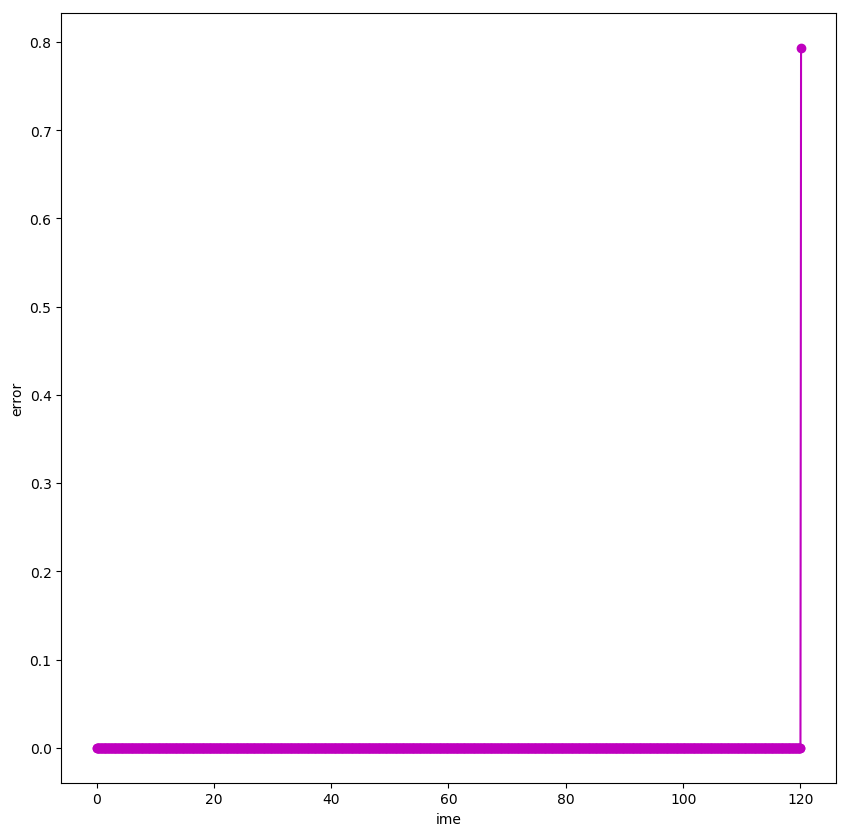

In [57]:
####### PLOT errors OF 1 RAT #######


# chose rat 
indexrat=1;
# chose Day
indexday= 1;
# chose trial
indextrial=20;

# Plot latency 
latencierat=[rats.experiment[1].day[div(k+numberoftrials-1,numberoftrials)].trial[rem(numberoftrials-1+k,numberoftrials)+1].Latency for k in 1:numberoftrials*numberofdays ]
using PyPlot
ioff()
fig = figure("Test plot latencies rat $(indexrat)",figsize=(10,10))
ax = fig[:add_subplot](1,1,1)

xlabel("ime")
ylabel("error")         

 
plot(0:dt:rats.experiment[indexrat].day[indexday].trial[indextrial].Latency, rats.experiment[indexrat].day[indexday].trial[indextrial].Error, marker="o",linestyle="-",color="m")

show()

#using Images
#save("/Users/pmxct2/Documents/FosterDayanMorris/latency_rats$(indexrat)_parameters$(rats.parameters).eps",fig)


In [40]:
# Computing positions of the dots of the platform 
# column 1 gives the x of the first quarter of the dots of the platform
# column 2 gives the y of the first quarter of the dots of the platform,
# column 3 gives the x of the second quarter of the dots of the platform,
# ....
function platform(xp,yp) # returns 8 arrays aith all the x and y positions of the 4th quarter of the platform
xplatform1=xp:0.01:xp+r;
yplatform1=sqrt.(r^2-(xplatform1.-xp).^2).+yp;
xplatform4=xp:0.01:xp+r;
yplatform4=-sqrt.(r^2-(xplatform4.-xp).^2).+yp;
xplatform2=xp-r:0.01:xp;
yplatform2=sqrt.(r^2-(xplatform2.-xp).^2).+yp;
xplatform3=xp-r:0.01:xp;
yplatform3=-sqrt.(r^2-(xplatform3.-xp).^2).+yp;

    return hcat(xplatform1,yplatform1,xplatform2,yplatform2,xplatform3,yplatform3,xplatform4,yplatform4)
end

platform (generic function with 1 method)

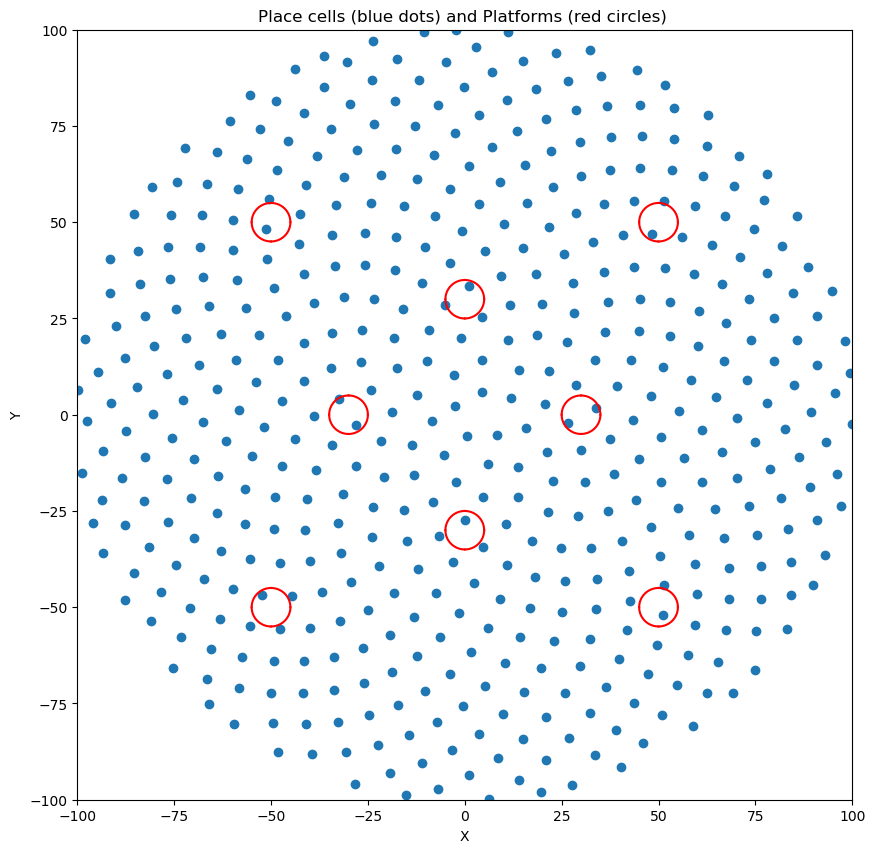

In [41]:

using PyPlot
ioff()
fig = figure("Test plot place cells",figsize=(10,10))
ax = fig[:add_subplot](1,1,1)

ax[:set_ylim]([-100,100])
ax[:set_xlim]([-100,100])
xlabel("X")
ylabel("Y")
title("Place cells (blue dots) and Platforms (red circles) ")

scatter(sunflower(493, 100, 2)[:,1] ,sunflower(493, 100, 2)[:,2])


for i=1:8
plot(platform(Xplatform[i],Yplatform[i])[:,1],platform(Xplatform[i],Yplatform[i])[:,2],color="r")
plot(platform(Xplatform[i],Yplatform[i])[:,3],platform(Xplatform[i],Yplatform[i])[:,4],color="r")
plot(platform(Xplatform[i],Yplatform[i])[:,5],platform(Xplatform[i],Yplatform[i])[:,6],color="r")
plot(platform(Xplatform[i],Yplatform[i])[:,7],platform(Xplatform[i],Yplatform[i])[:,8],color="r")
end




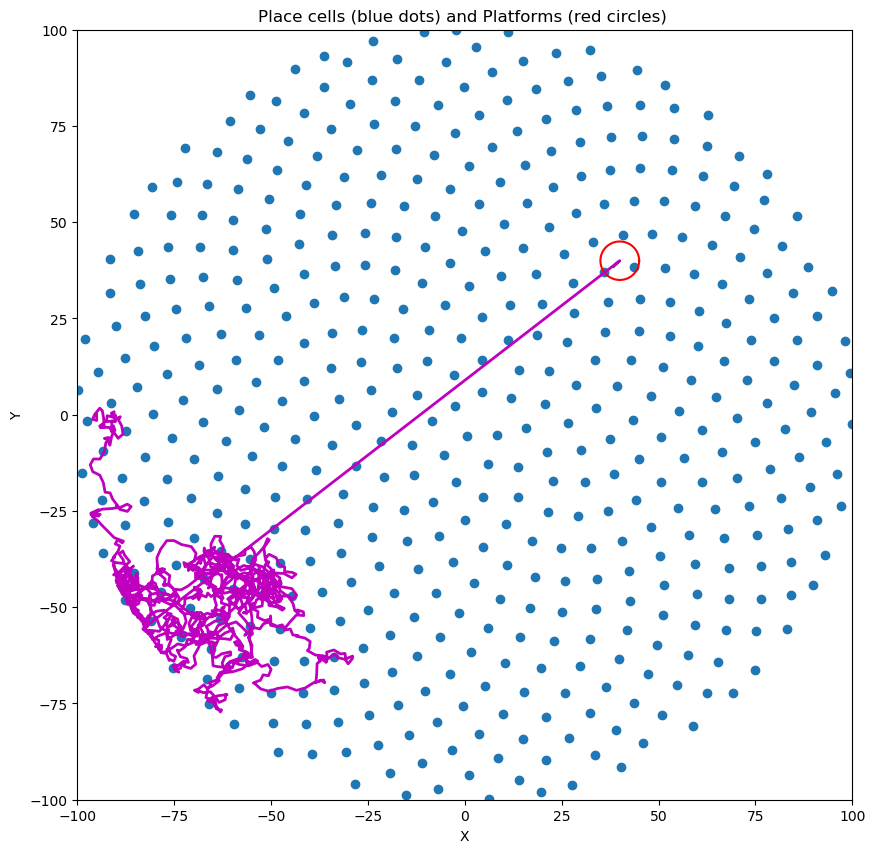

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x12d14a750>

In [70]:

# chose rat 
indexrat=1;
# chose Day
indexday= 1;
# chose trial
indextrial=20;


################## Plotting one trajectories #########
using PyPlot
ioff()
fig = figure("Test plot place cells",figsize=(10,10))
ax = fig[:add_subplot](1,1,1)

ax[:set_ylim]([-100,100])
ax[:set_xlim]([-100,100])
xlabel("X")
ylabel("Y")
title("Place cells (blue dots) and Platforms (red circles) ")

scatter(sunflower(493, 100, 2)[:,1] ,sunflower(493, 100, 2)[:,2])

theta=0:0.01:2*pi;
plot(rats.experiment[indexrat].day[indexday].Platform[1]+r*cos.(theta),rats.experiment[indexrat].day[indexday].Platform[2]+r*sin.(theta),color="r")

plot(rats.experiment[indexrat].day[indexday].trial[indextrial].Trajectory[:,1],rats.experiment[indexrat].day[indexday].trial[indextrial].Trajectory[:,2],"m-", lw=2.0)


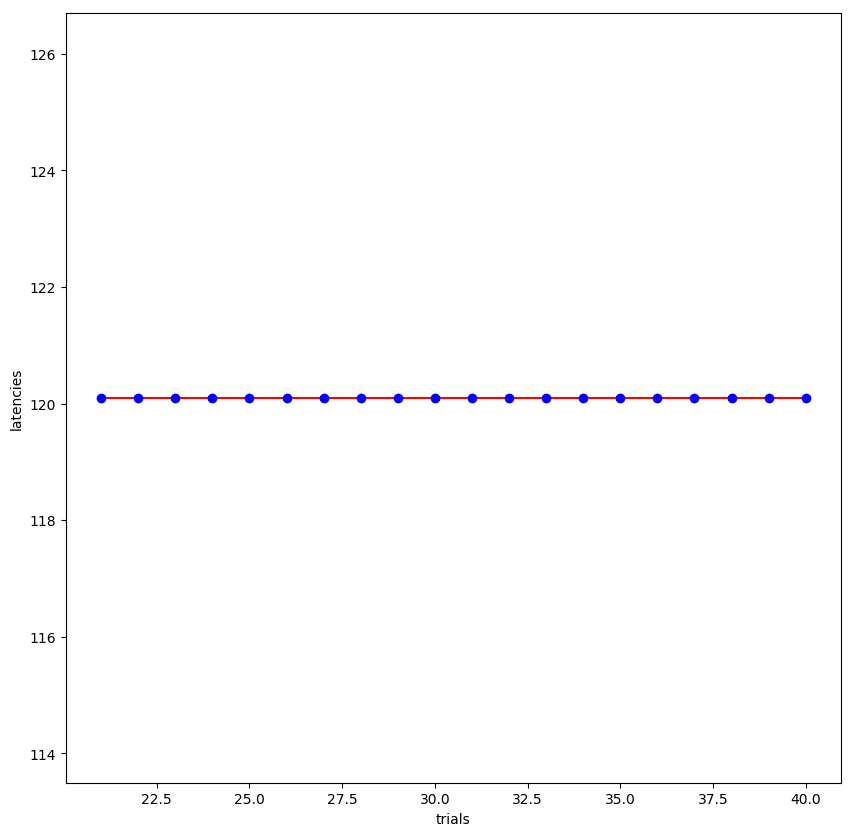

In [71]:

####### PLOT LATENCIES ##### 

using PyPlot
ioff()
fig = figure("Test plot latencies",figsize=(10,10))
ax = fig[:add_subplot](1,1,1)

xlabel("trials")
ylabel("latencies")         


for k=1:numberofdays
    
# Calculate standard deviation 
#err=[std([rats.experiment[n].day[k].trial[i].Latency for n in 1:numberofrats]; corrected=false) for i in 1:numberoftrials] ;

# Calculate the lower value for the error bar : 
uppererror = [std([rats.experiment[n].day[k].trial[i].Latency for n in 1:numberofrats]; corrected=false) for i in 1:numberoftrials]./sqrt(numberofrats) ;
lowererror = [std([rats.experiment[n].day[k].trial[i].Latency for n in 1:numberofrats]; corrected=false) for i in 1:numberoftrials]./sqrt(numberofrats) ;

errs=[lowererror,uppererror];

plot(k*numberoftrials.+(1:numberoftrials), [mean([rats.experiment[n].day[k].trial[i].Latency for n in 1:numberofrats]) for i in 1:numberoftrials ], marker="None",linestyle="-",color="r",label="Base Plot")
  
errorbar(k*numberoftrials.+(1:numberoftrials),[mean([rats.experiment[n].day[k].trial[i].Latency for n in 1:numberofrats]) for i in 1:numberoftrials ],yerr=errs,fmt="o",color="b")

end 
show()

#using Images
#save("/Users/pmxct2/Documents/FosterDayanMorris/latencies_parameters$(rats.parameters).eps",fig)

In [39]:


# chose rat 
indexrat=1;
# chose Day
indexday=1;
# chose trial
indextrial=3;

argument=0:pi/50:2pi;
xplat=r*cos.(argument);
yplat=r*sin.(argument);
xmaze=R*cos.(argument);
ymaze=R*sin.(argument);


#Declare a figure object 
using PyPlot
ioff()
fig = figure("Test plot Trajectory",figsize=(16,4))



ax1 = subplot(141) # Create the 1st axis of a 2x2 arrax of axes
# grid("on") # Create a grid on the axis
title("Trial1") # Give the most recent axis a title
ax1[:set_ylim]([-100,100])
ax1[:set_xlim]([-100,100])
xlabel("X")
ylabel("Y")


# Plot place cells 
scatter(sunflower(493, 100, 2)[:,1] ,sunflower(493, 100, 2)[:,2])

# plot platform
plot(rats.experiment[indexrat].day[indexday].Platform[1]+xplat,rats.experiment[indexrat].day[indexday].Platform[2] + yplat,color="red")

# Plot circle
plot(xmaze,ymaze)

# Plot trajectory 
plot(rats.experiment[indexrat].day[indexday].trial[1].Trajectory[:,1],rats.experiment[indexrat].day[indexday].trial[1].Trajectory[:,2],"m-", lw=0.5)
ax2 = subplot(142) # Create a plot and make it a polar plot, 2nd axis of 2x2 axis grid
title("Trial2")
ax2[:set_ylim]([-100,100])
ax2[:set_xlim]([-100,100])
xlabel("X")
ylabel("Y")

scatter(sunflower(493, 100, 2)[:,1] ,sunflower(493, 100, 2)[:,2])
plot(rats.experiment[indexrat].day[indexday].Platform[1]+xplat,rats.experiment[indexrat].day[indexday].Platform[2] + yplat,color="red")
# Plot circle
plot(xmaze,ymaze)

plot(rats.experiment[indexrat].day[indexday].trial[2].Trajectory[:,1],rats.experiment[indexrat].day[indexday].trial[2].Trajectory[:,2],"m-", lw=0.5)

ax3 = subplot(143) # Create a plot and make it a polar plot, 3rd axis of 2x2 axis grid
title("Trial3")
ax3[:set_ylim]([-100,100])
ax3[:set_xlim]([-100,100])
xlabel("X")
ylabel("Y")

scatter(sunflower(493, 100, 2)[:,1] ,sunflower(493, 100, 2)[:,2])
plot(rats.experiment[indexrat].day[indexday].Platform[1]+xplat,rats.experiment[indexrat].day[indexday].Platform[2] + yplat,color="red")
# Plot circle
plot(xmaze,ymaze)

plot(rats.experiment[indexrat].day[indexday].trial[3].Trajectory[:,1],rats.experiment[indexrat].day[indexday].trial[3].Trajectory[:,2],"m-", lw=0.5)

ax4 = subplot(144) # Create the 4th axis of a 2x2 arrax of axes
# xlabel("This is an X axis")
# ylabel("This is a y axis")
title("Trial4")

ax4[:set_ylim]([-100,100])
ax4[:set_xlim]([-100,100])
xlabel("X")
ylabel("Y")

scatter(sunflower(493, 100, 2)[:,1] ,sunflower(493, 100, 2)[:,2])
plot(rats.experiment[indexrat].day[indexday].Platform[1]+xplat,rats.experiment[indexrat].day[indexday].Platform[2] + yplat,color="red")
# Plot circle
plot(xmaze,ymaze)
plot(rats.experiment[indexrat].day[indexday].trial[4].Trajectory[:,1],rats.experiment[indexrat].day[indexday].trial[4].Trajectory[:,2],"m-", lw=0.5)

# fig[:canvas][:draw]() # Update the figure
suptitle("Trajectories Rat $(indexrat), parameter : alpha $(α) beta $(β) Leaning : γ $(γ), Z $(Z), W $(W)")

#gcf() # Needed for IJulia to plot inline

show()

#using Images
#save("/Users/pmxct2/Documents/FosterDayanMorris/day$(indexday)rat$(indexrat)_parameters$(rats.parameters).eps",fig)


LoadError: [91mBoundsError: attempt to access 0-element Array{Experiment,1} at index [1][39m

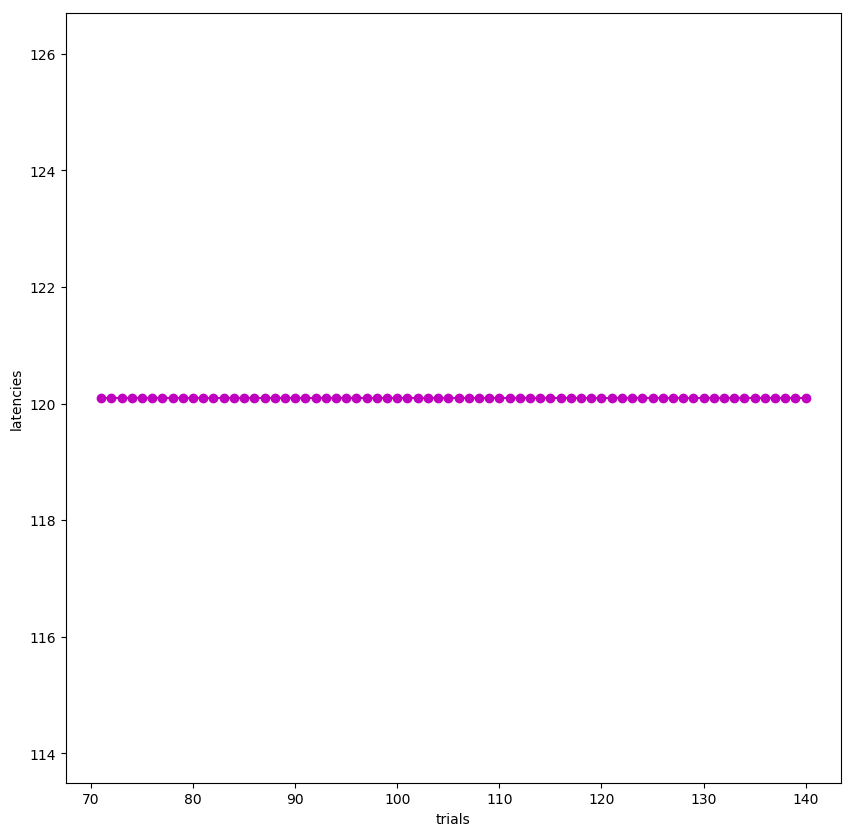

In [37]:
####### PLOT LATENCY OF 1 RAT #######


# chose rat 
indexrat=1;


# Plot latency 
latencierat=[rats.experiment[1].day[div(k+numberoftrials-1,numberoftrials)].trial[rem(numberoftrials-1+k,numberoftrials)+1].Latency for k in 1:numberoftrials*numberofdays ]
using PyPlot
ioff()
fig = figure("Test plot latencies rat $(indexrat)",figsize=(10,10))
ax = fig[:add_subplot](1,1,1)

xlabel("trials")
ylabel("latencies")         

 
for k=1:numberofdays
plot(k*numberoftrials.+(1:numberoftrials), [rats.experiment[indexrat].day[k].trial[i].Latency for i in 1:numberoftrials ], marker="o",linestyle="-",color="m")

end 
show()

#using Images
#save("/Users/pmxct2/Documents/FosterDayanMorris/latency_rats$(indexrat)_parameters$(rats.parameters).eps",fig)


In [38]:
#########################################################################
#############          LOOP       1   EXPERIMENT   ######################
#########################################################################

rats=Rat();
rats.parameters=[momentum,γ,Z,W]; # Save different parameters 

for indexrat=1:numberofrats

# Initialisation variables :
w=rand(N);
z=rand(N,n);    
    
        ##########  ##########  ##########  ##########   ########## 
    ##########  ##########  START EXPERIMENT  ##########  ##########  
        ##########  ##########  ##########  ##########   ########## 

currentexperiment=Experiment(); # Creating the experiment 
currentexperiment.PlaceCells=hcat(Xplacecell,Yplacecell); # Store location of place cells 
    
    for indexday=1:numberofdays

        # Everyday the location of the platform changes
        # Chose platform :
        indexplatform=rand(1:8); # take ith platform 
        xp=Xplatform[indexplatform];
        yp=Yplatform[indexplatform]; 
        
            
        
            ##########  ##########  ##########  ##########  
        ##########  ##########  START DAY ##########  ##########  
            ##########  ##########  ##########  ##########  
            
        currentday=Day(); # creating a day 
        currentday.Platform=hcat(xp,yp);   
        
        for indextrial=1:numberoftrials ##########  
            
            # Chose starting position :
                    
            indexstart=rand(1:4); # take indexstart-th starting position : chose randomnly between 4 possibilities 1 East 2 North 3 West 4 South
            X=Xstart[indexstart];
            Y=Ystart[indexstart];
            
                
            # compute activity of pace cells :
                
            actplacecell=place_activity(X,Y,Xplacecell,Yplacecell,σ);
                
            #  Compute action cell activity 
                    
            actactioncell=transpose(z)*actplacecell; # careful z contains place cells in rows and action cells in column 
            
            
            # Initialise Critic 
            C=dot(w,actplacecell);
            
            # Initialize reward 
            re=0;
            
            # initialise time 
            t=0;
            
            # Initialise index to save the trajectory and the values 
            k=1;
            historyX=Float64[];
            historyY=Float64[];
            #valuemap=Float64[];
            error=Float64[];
            searchpref=0;
            arg=0;        
                    
                
            ##########  ##########  ##########  ##########   ########## 
            ##########  ##########  START TRIAL ##########  ##########  
            ##########  ##########  ##########  ##########   ########## 
                    
            while t<=T && re==0
                ####### Take decision : ########
                
                # Compute probability distribution : 
                Pactioncell=exp.(2.*actactioncell)./sum(exp.(2.*actactioncell)); 
                # Compute summed probability distribution:
                SumPactioncell=cumul(Pactioncell);
                # Generate uniform number between 0 and 1 :
                x=rand();
                # println(SumPactioncell)
                # now chose action: 
                indexaction=indice(SumPactioncell,x); # Chose which action between the 8 psosibilities
                #println(indexaction)
                formerarg=arg;

                argdecision=angles[indexaction]; # compute the coreesponding angle 
                arg=α*formerarg+β*argdecision; # to constrain the angle to prevent from sharp angles
                # arg=argdecision; # not good because angles too sharp

                push!(historyX,X) # Store former position to be able to draw trajectory
                push!(historyY,Y)
                
                # Store former position 
                
                
                
                
                
                
                
                
                (Xf,Yf)=[X,Y];
                
                
                
                
                
                
                
                # Compute new position : 
                (X,Y)=[X,Y].+dt.*speed.*[cos(arg),sin(arg)]; 
                
                
                
                # Here we have to check that we are still in the circle : 
                # If we are out of the circle we compute the symetric of the position against the bordure of the circle 
                # as they explain that the walls act as reflector
                #if X^2+Y^2>R^2 # if we are out of the circle 
                #    Xnew=(X/sqrt(X^2+Y^2))*(R-sqrt(X^2+Y^2));
                #    Ynew=(Y/sqrt(X^2+Y^2))*(R-sqrt(X^2+Y^2));
                #    X=Xnew;
                #    Y=Ynew;
                #end
                
                
                
                
                
                
                
                # We code walls as reflectors :
                
                
                if X^2+Y^2>R^2 # if we are out of the circle 
                # find the position between former position and current position that is exactly on the circle :
                # Create Polynomial with a parameter lambda that represent the absciss along the segment
                # search the value of lambda for which we are crossing the circle    
                poly=Poly([Xf^2+Yf^2-R^2,2*X*Xf+2*Y*Yf-2*Xf^2-2*Yf^2,Xf^2+Yf^2+X^2+Y^2-2*X*Xf-2*Y*Yf]); # using poly creates a polynomial, coefficient are in order of increasing exposant 
                # find the root of this polynomial that is between 0 and 1 (there is just one by I dont know which theorem)
                λ=roots(poly)[find(x -> 0<x <1,roots(poly))];
                λ=maximum(λ); # to convert from array of float to float 
                Xlambda=λ*X+(1-λ)Xf; # position of the point that is on the circle 
                Ylambda=λ*Y+(1-λ)Yf;
                delta=norm([Xlambda-X,Ylambda-Y]); # distance of the point to Xlambda Ylambda
                    
                #anglereflect=acos(dot([Xlambda, Ylambda],[Xf-Xlambda,Yf-Ylambda])/(norm([Xlambda, Ylambda])*norm([Xf-Xlambda,Yf-Ylambda]))); # compute the angle between the former position and the radius linking the point in the circle to the center 
                #anglerotation=acos(Xlambda/norm([Xlambda, Ylambda])); # angle of rotation to calculate the new coordonnee, angle between the point in the circle and the x axis
                # Find the intersection between the line starting from X,Y in the direction of Xlambda and Ylambda and the circle of centre Xlambda Ylambda of radius delta
                poly2=Poly([Y^2-2*Ylambda*Y+(Ylambda^2)+X^2-2*Xlambda*X+(Xlambda^2)-delta^2, -2*Ylambda*Y/R+2*Ylambda^2/R-2*Xlambda*X/R+2*Xlambda^2/R ,Ylambda^2/R^2+Xlambda^2/R^2]);

                
                
                # Problem with root is the precision : sometimes the first root given is reaaally near the first point in which case we want the second root
                
                deplacement=maximum(roots(poly2)[find(x -> 0<x ,roots(poly2))]); 
                
                    
                # Compute new position : we just move following the inverse vector of Xlambda,Ylambda of the distance we computed
                Xnew=X-deplacement*Xlambda/R;
                Ynew=Y-deplacement*Ylambda/R;
                    
                
                #X=-delta*cos(anglerotation)*cos(anglereflect)-delta*sin(anglerotation)*sin(anglereflect)+delta*sin(anglerotation)*cos(anglereflect)+delta*cos(anglerotation)*sin(anglereflect)+Xlambda;   
                #Y=-delta*sin(anglerotation)*cos(anglereflect)+delta*sin(anglerotation)*sin(anglereflect)-delta*cos(anglerotation)*cos(anglereflect)+delta*cos(anglerotation)*sin(anglereflect)+Ylambda;   
                 
                    if Xnew^2+Ynew^2>R^2 
                        
                        break  
                    end
                X=Xnew;
                Y=Ynew;
                end
                
                
                # compute new activity of pace cells :
                actplacecell=place_activity(X,Y,Xplacecell,Yplacecell,σ);
                
                
                ######### Compute Error : ########
                ### Compute Critic ###
                # Save the former value
                Cformer=C;
                # Compute new value 
                C=dot(w,actplacecell);
                
                ###  Compute reward ### 
                re=reward(X,Y,xp,yp,r);
                
                ###  Compute error ###
                
                err=re+γ*C-Cformer;
                # Save error 
                push!(error,err);
                
                ######### Compute new weights : ########
                
                # weights between action cells and place cells 
                z[:,indexaction]=z[:,indexaction]+Z.*err.*actplacecell; # only the weights between place cells and the action taken are updated
                
                # weights between critic and place cells :
                # Save value to draw valuemap
                # push!(valuemap,w);
                w=w+W.*err.*actplacecell;
                
                #println(w)
                
                actactioncell=transpose(z)*actplacecell; # careful z contains place cells in rows and action cells in column 
                
                
                 ####### ####### ####### Updating search preference  ####### ####### #######
                if (X-xp)^2+(Y-yp)^2<= radiussearchpref^2          
                searchpref=searchpref+1*dt;
                end
                        
                        
                t=t+dt;
                k=k+1;
            ##################################################            
            end
            ########## ##########  END TRIAL ########## ########## 

            


            
            push!(historyX,X) # Store the last position visited 
            push!(historyY,Y)
            # push!(valuemap,w)
                        

  
            ############### SAVING THE THINGS IN THE DIFFERENT CLASS ################
            ## in creating a new trial type one should write Trial(Trajectory, latency, searchpreference, actionmap) # action map atm is just z, then it will be improved adding a new attribute being value map 
            
            currenttrial=Trial(hcat(historyX,historyY),t,searchpref,z,w,error); # Creating the current trial with all its fields
            push!(currentday.trial,currenttrial) # Storing it in the current day 
              
            
            println("trial$(size(currentday.trial))")            


            
            
        ##################################################     
        end 
        ########## ##########  END DAY ########## ##########
        
        
        push!(currentexperiment.day,currentday) # Storing the current day in the current experiment 
        
            
    ##################################################     
    end 
    ########## ##########  END EXPERIMENT ########## ##########

push!(rats.experiment,currentexperiment) # Storing the current experiment in the rat's class

##################################################     
end 
########## ##########  END RATS ########## ###

trial(1,)
trial(2,)
trial(3,)
trial(4,)
trial(5,)
trial(6,)
trial(7,)
trial(8,)
trial(9,)
trial(10,)
trial(11,)
trial(12,)
trial(13,)
trial(14,)
trial(15,)
trial(16,)
trial(17,)
trial(18,)
trial(19,)
trial(20,)
trial(21,)
trial(22,)
trial(23,)
trial(24,)
trial(25,)
trial(26,)
trial(27,)
trial(28,)
trial(29,)
trial(30,)
trial(31,)
trial(32,)
trial(33,)
trial(34,)
trial(35,)
trial(36,)


LoadError: [91mArgumentError: invalid index: nothing[39m